This is needed to reload modules without restarting the kernel

In [2]:
%load_ext autoreload
%autoreload 2

This is needed to add eda_tools from the directories above

In [3]:
import os
os.sys.path.append('../../')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uproot

In [5]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

**This function might be needed for later and might come in handy**

In [6]:
from scipy import interpolate

In [7]:
def weighted_histogram_iqr(h, edges):

    x = bin_midpoint(edges)
    cf = np.zeros(len(x))
    count = 0

    for i, _ in enumerate(cf):
        count = count + h[i]
        cf[i] = count

    cp = 100 * cf / sum(h)

    d = interpolate.interp1d(cp, x)
    iqr = d(75) - d(25)
    return iqr

In [8]:
def weighted_histogram_ecdf(h, edges, q):

    x = bin_midpoint(edges)
    cf = np.zeros(len(x))
    count = 0

    for i, _ in enumerate(cf):
        count = count + h[i]
        cf[i] = count

    cp = 100 * cf / sum(h)

    d = interpolate.interp1d(cp, x)
    return d(q)

# XGBoost Reweighting Analysis

Lets analyze the results of the full XGBoost reweighting

In [9]:
!ls -lh /mnt/storage/lborgna/NNT/MDR_VEC/data/xgboost

total 2.2G
-rw-r--r-- 1 lborgna users 533M Feb 25 22:03 data_MDR_VEC_16_with_weights.root
-rw-r--r-- 1 lborgna users 481M Feb 25 22:04 data_MDR_VEC_17_with_weights.root
-rw-r--r-- 1 lborgna users 1.2G Feb 25 22:05 data_MDR_VEC_18_with_weights.root
drwxr-xr-x 2 lborgna users 4.0K Mar  9 14:38 weights


nominal dataset

In [10]:
!ls -lh /mnt/storage/lborgna/NNT/MDR_VEC/data/data_MDR_VEC*

-rw-r--r-- 1 lborgna users 534M Feb 25 01:17 /mnt/storage/lborgna/NNT/MDR_VEC/data/data_MDR_VEC_16_NN_100_bootstraps.root
-rw-r--r-- 1 lborgna users 482M Feb 25 01:17 /mnt/storage/lborgna/NNT/MDR_VEC/data/data_MDR_VEC_17_NN_100_bootstraps.root
-rw-r--r-- 1 lborgna users 1.2G Feb 25 01:19 /mnt/storage/lborgna/NNT/MDR_VEC/data/data_MDR_VEC_18_NN_100_bootstraps.root


In [11]:
def load_nnt(
    file_path: str, trees: list = ["control", "validation", "sig"]
) -> pd.DataFrame:
    """"""
    list_of_dataframes = []

    for tree in trees:
        _df = uproot.open(file_path)[tree].pandas.df()
        list_of_dataframes.append(_df)

    df = pd.concat(list_of_dataframes)
    df = df.reset_index(drop=True)
    return df

In [12]:
def get_mu(file, year:int=16,vr:bool=False)->float:
    vr_fix = "_VRderiv" if vr else ""
    return file[f'NN_norm{vr_fix}_bstrap_med_{year}']._fVal
def get_mu_iqr(file, year:int=16,vr:bool=False)->float:
    vr_fix = "_VRderiv" if vr else ""
    return file[f'NN_norm{vr_fix}_bstrap_IQR_{year}']._fVal

In [13]:
def w_col(year:int, vr:bool=False)->str:
    vr_prefix = "_VRderiv" if vr else ""
    return f"NN_d24_weight{vr_prefix}_bstrap_med_{year}"

In [14]:
def w_iqr(year:int, vr:bool=False)->str:
    vr_prefix = "_VRderiv" if vr else ""
    return f"NN_d24_weight{vr_prefix}_bstrap_IQR_{year}"

**BASELINE**

In [15]:
storage = '/mnt/storage/lborgna/NNT/MDR_VEC/data/'

In [16]:
fbp16 = storage + 'data_MDR_VEC_16_NN_100_bootstraps.root'
fbp17 = storage + 'data_MDR_VEC_17_NN_100_bootstraps.root'
fbp18 = storage + 'data_MDR_VEC_18_NN_100_bootstraps.root'

In [17]:
fdb16 = uproot.open(fbp16)
fdb17 = uproot.open(fbp17)
fdb18 = uproot.open(fbp18)

In [18]:
data_b16 = load_nnt(fbp16)
data_b17 = load_nnt(fbp17)
data_b18 = load_nnt(fbp18)

In [19]:
bs_dict_b16 = {
    "W_med": w_col(16),
    "weight_IQR_column": w_iqr(16),
    "W_IQR": w_iqr(16),
    "mu_med": get_mu(fdb16, 16),
    "mu_QCD_IQR": get_mu_iqr(fdb16, 16),
    "mu_IQR": get_mu_iqr(fdb16, 16)
}

In [20]:
bs_dict_b17 = {
    "W_med": w_col(17),
    "weight_IQR_column": w_iqr(17),
    "W_IQR": w_iqr(17),
    "mu_med": get_mu(fdb17, 17),
    "mu_QCD_IQR": get_mu_iqr(fdb17, 17),
    "mu_IQR": get_mu_iqr(fdb17, 17)
}

In [21]:
bs_dict_b18 = {
    "W_med": w_col(18),
    "weight_IQR_column": w_iqr(18),
    "W_IQR": w_iqr(18),
    "mu_med": get_mu(fdb18, 18),
    "mu_QCD_IQR": get_mu_iqr(fdb18, 18),
    "mu_IQR": get_mu_iqr(fdb18, 18)
}

**XGBOOST**

In [22]:
storage = "/mnt/storage/lborgna/NNT/MDR_VEC/data/xgboost/"

In [23]:
fp16 = storage + 'data_MDR_VEC_16_with_weights.root'
fp17 = storage + 'data_MDR_VEC_17_with_weights.root'
fp18 = storage + 'data_MDR_VEC_18_with_weights.root'

In [24]:
fd16 = uproot.open(fp16)
fd17 = uproot.open(fp17)
fd18 = uproot.open(fp18)

In [25]:
fd16.keys()

[b'validation;1',
 b'sig;1',
 b'control;1',
 b'NN_norm_bstrap_med_16;1',
 b'NN_norm_bstrap_IQR_16;1',
 b'NN_norm_bstrap_perc_25_16;1',
 b'NN_norm_bstrap_perc_75_16;1',
 b'NN_norm_VRderiv_bstrap_med_16;1',
 b'NN_norm_VRderiv_bstrap_IQR_16;1',
 b'NN_norm_VRderiv_bstrap_perc_25_16;1',
 b'NN_norm_VRderiv_bstrap_perc_75_16;1']

In [26]:
data16 = load_nnt(fp16)
data17 = load_nnt(fp17)
data18 = load_nnt(fp18)

In [27]:
bs_dict16 = {
    "W_med": w_col(16),
    "weight_IQR_column": w_iqr(16),
    "W_IQR": w_iqr(16),
    "mu_med": get_mu(fd16, 16),
    "mu_QCD_IQR": get_mu_iqr(fd16, 16),
    "mu_IQR": get_mu_iqr(fd16, 16)
}

In [28]:
bs_dict17 = {
    "W_med": w_col(17),
    "weight_IQR_column": w_iqr(17),
    "W_IQR": w_iqr(17),
    "mu_med": get_mu(fd17, 17),
    "mu_QCD_IQR": get_mu_iqr(fd17, 17),
    "mu_IQR":get_mu_iqr(fd17, 17)
}

In [29]:
bs_dict18 = {
    "W_med": w_col(18),
    "weight_IQR_column": w_iqr(18),
    "W_IQR": w_iqr(18),
    "mu_med": get_mu(fd18, 18),
    "mu_QCD_IQR": get_mu_iqr(fd18, 18),
    "mu_IQR": get_mu_iqr(fd18, 18)
}

**Signal**

In [98]:
!ls -lh /mnt/storage/lborgna/NNT/MDR_VEC/mc/*mc16*.root

-rw-r--r-- 1 lborgna users  73M Feb 25 02:33 /mnt/storage/lborgna/NNT/MDR_VEC/mc/SMNR_600043_mc16a_b.root
-rw-r--r-- 1 lborgna users  73M Mar  2 23:57 /mnt/storage/lborgna/NNT/MDR_VEC/mc/SMNR_600043_mc16a.root
-rw-r--r-- 1 lborgna users  17M Feb 23 23:28 /mnt/storage/lborgna/NNT/MDR_VEC/mc/SMNR_600043_mc16a_two_buckets.root
-rw-r--r-- 1 lborgna users  78M Feb 25 02:14 /mnt/storage/lborgna/NNT/MDR_VEC/mc/SMNR_600043_mc16d_b.root
-rw-r--r-- 1 lborgna users  78M Mar  2 23:57 /mnt/storage/lborgna/NNT/MDR_VEC/mc/SMNR_600043_mc16d.root
-rw-r--r-- 1 lborgna users  19M Feb 23 23:28 /mnt/storage/lborgna/NNT/MDR_VEC/mc/SMNR_600043_mc16d_two_buckets.root
-rw-r--r-- 1 lborgna users 140M Feb 25 02:13 /mnt/storage/lborgna/NNT/MDR_VEC/mc/SMNR_600043_mc16e_b.root
-rw-r--r-- 1 lborgna users 140M Mar  2 23:58 /mnt/storage/lborgna/NNT/MDR_VEC/mc/SMNR_600043_mc16e.root
-rw-r--r-- 1 lborgna users  30M Feb 23 23:28 /mnt/storage/lborgna/NNT/MDR_VEC/mc/SMNR_600043_mc16e_two_buckets.root


In [99]:
storage_mc = '/mnt/storage/lborgna/NNT/MDR_VEC/mc/'

In [100]:
fps16 = storage_mc + 'SMNR_600043_mc16a.root'
fps17 = storage_mc + 'SMNR_600043_mc16d.root'
fps18 = storage_mc + 'SMNR_600043_mc16e.root'

In [101]:
sig16 = load_nnt(fps16) 
sig17 = load_nnt(fps17)
sig18 = load_nnt(fps18)

## Stats Check

In [103]:
from hh4b_utils.stat_tools import stats_check, lumi

In [30]:
help(stats_check)

NameError: name 'stats_check' is not defined

**Baseline**

In [110]:
stats_check_b16 = stats_check(sig16, data_b16, lumi(16), bkg_weights='NN_d24_weight_bstrap_med_16')

{'s': 6.367670150220394, 'b': 3061.7386267324387, 'norm': 0.008922023132666313, 'norm_w': 1.059218902814278, 's/b': 0.0020797562844272325, 'srootb': 0.1150791119712025, 'sig_mhh': 0.00574394493601832}


In [111]:
stats_check_b17 = stats_check(sig17, data_b17, lumi(17), bkg_weights='NN_d24_weight_bstrap_med_17')

{'s': 9.365376875591279, 'b': 4019.5976979337483, 'norm': 0.013506803058893634, 'norm_w': 1.053301044142129, 's/b': 0.00232992890816051, 'srootb': 0.14771818546901422, 'sig_mhh': 0.0038670635745963514}


In [112]:
stats_check_b18 = stats_check(sig18, data_b18, lumi(18), bkg_weights='NN_d24_weight_bstrap_med_18')

{'s': 14.461870193481445, 'b': 7170.807124327931, 'norm': 0.009708114460226373, 'norm_w': 1.0526397923594204, 's/b': 0.0020167702104854556, 'srootb': 0.1707813484960255, 'sig_mhh': 0.00343259894602752}


**XGBoost**

In [104]:
stats_check16 = stats_check(sig16, data16, lumi(16), bkg_weights='NN_d24_weight_bstrap_med_16')

{'s': 6.367670150220394, 'b': 3260.9259670593196, 'norm': 0.008922023132666313, 'norm_w': 1.0083747507007308, 's/b': 0.0019527184040803952, 'srootb': 0.1115090431016639, 'sig_mhh': 0.005580179644516191}


In [105]:
stats_check17 = stats_check(sig17, data17, lumi(17), bkg_weights='NN_d24_weight_bstrap_med_17')

{'s': 9.365376875591279, 'b': 4361.082500883239, 'norm': 0.013506803058893634, 'norm_w': 1.005265031666611, 's/b': 0.0021474890405523248, 'srootb': 0.1418169390481068, 'sig_mhh': 0.003764647542898205}


In [106]:
stats_check18 = stats_check(sig18, data18, lumi(18), bkg_weights='NN_d24_weight_bstrap_med_18')

{'s': 14.461870193481445, 'b': 7661.181682851986, 'norm': 0.009708114460226373, 'norm_w': 1.005040323297906, 's/b': 0.0018876814037515168, 'srootb': 0.16522531109882432, 'sig_mhh': 0.0033842045014342843}


# M_hh Check

In [129]:
def plot_mhh(
    sig: pd.DataFrame, bkg: pd.DataFrame, mu,L=1, bkg_weights="NN_d24_weight_bstrap_med_17"
):

    mask_4b = sig["ntag"] >= 4
    mask_sig_sr = sig["kinematic_region"] == 0
    mask_bkg_sr = bkg["kinematic_region"] == 0
    mask_2b = bkg["ntag"] == 2

    f, ax = plt.subplots(figsize=(10, 6))

    h_S, be, _ = ax.hist(
        sig.loc[mask_4b & mask_sig_sr, "m_hh"].values,
        bins=50,
        range=(200, 1200),
        weights= L * sig.loc[mask_4b & mask_sig_sr, "mc_sf"].values,
        label="signal",
        histtype='step',
        density = True
    )

    _ = ax.hist(
        bkg.loc[mask_2b & mask_bkg_sr, "m_hh"].values,
        bins=be,
        weights= mu * bkg.loc[mask_2b & mask_bkg_sr, bkg_weights].values,
        label="background",
        histtype='step',
        density = True
    )
    ax.legend(fontsize = 14)
    return ax

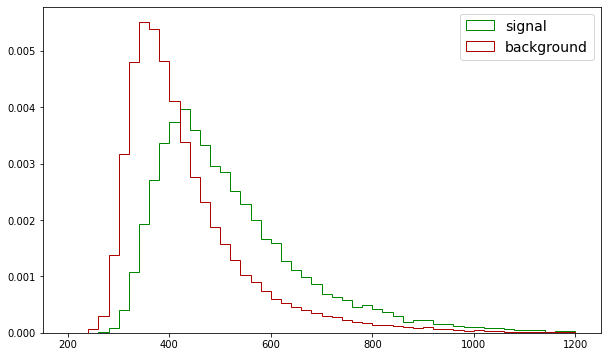

In [130]:
ax = plot_mhh(sig16, data16, get_mu(fd16, 16), lumi(16), bkg_weights='NN_d24_weight_bstrap_med_16')

In [224]:
from eda_tools.histogram_helper import bin_midpoint, median_histogram

In [174]:
import seaborn as sns

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, '2016 SR Baseline vs XGBoost comparison')

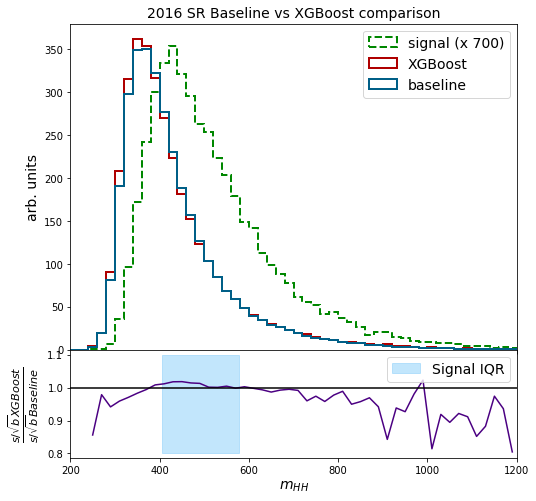

In [245]:
f, ax = plt.subplots(
    2, 1, figsize=(8, 8), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
)

mask_4b = sig16["ntag"] >= 4
mask_sr = sig16["kinematic_region"] == 0

L = lumi(16)

h_s, be = np.histogram(
    sig16.loc[mask_4b & mask_sr, "m_hh"].values,
    bins=50,
    range=(200, 1200),
    weights=L * sig16.loc[mask_4b & mask_sr, "mc_sf"],
)
median = median_histogram(h_s, be)
q25 = weighted_histogram_ecdf(h_s,be,25)
q75 = weighted_histogram_ecdf(h_s, be, 75)
x = bin_midpoint(be)

_ = ax[0].hist(
    sig16.loc[(sig16["ntag"] >= 4) & (sig16["kinematic_region"] == 0), "m_hh"].values,
    histtype="step",
    bins=be,
    label="signal (x 700)",
    ls="--",
    lw=2,
    density=False,
    weights=700
    * L
    * sig16.loc[
        (sig16["ntag"] >= 4) & (sig16["kinematic_region"] == 0), "mc_sf"
    ].values,
)


mus = [get_mu(fd16, 16), get_mu(fdb16, 16)]
hbs = []
labels = ["XGBoost", "baseline"]
for _df, l, mu in zip([data16, data_b16], labels, mus):
    mask_2b = _df["ntag"] == 2
    mask_sr = _df["kinematic_region"] == 0
    w_name = w_col(16)

    h_b, _, _ = ax[0].hist(
        _df.loc[mask_2b & mask_sr, "m_hh"].values,
        bins=be,
        weights=mu * _df.loc[mask_2b & mask_sr, w_name].values,
        histtype="step",
        lw=2,
        label=l,
        density=False,
    )
    hbs.append(h_s / np.sqrt(h_b))
    # ax[1].plot(x, h_s / np.sqrt(h_b), marker=".", linewidth=0, label=l)

ax[1].plot(x, hbs[0] / hbs[1], color="indigo")

ax[1].fill_betweenx(
    np.linspace(0.8, 1.1, 20),
    q25,
    q75,
    color="lightskyblue",
    alpha=0.5,
    label = 'Signal IQR'
)
ax[1].axhline(1, color="black")
ax[0].legend(fontsize=14)
ax[1].legend(loc='upper right', fontsize=14)
plt.subplots_adjust(hspace=0)
ax[0].set_xlim(200, 1200)
ax[1].set_ylabel(r"$\frac{s/\sqrt{b} XGBoost}{s/\sqrt{b} Baseline}$", fontsize=16)

ax[1].set_xlabel(r"$m_{HH}$", fontsize=14)
ax[0].set_ylabel("arb. units", fontsize=14)
ax[0].set_title("2016 SR Baseline vs XGBoost comparison", fontsize=14)

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, '2017 SR Baseline vs XGBoost comparison')

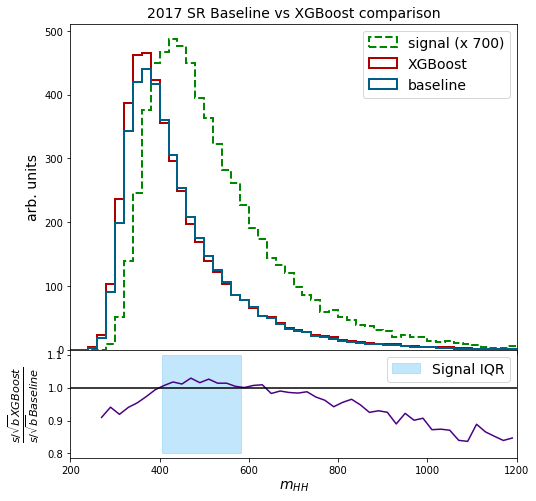

In [246]:
f, ax = plt.subplots(
    2, 1, figsize=(8, 8), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
)

mask_4b = sig17["ntag"] >= 4
mask_sr = sig17["kinematic_region"] == 0

L = lumi(17)

h_s, be = np.histogram(
    sig17.loc[mask_4b & mask_sr, "m_hh"].values,
    bins=50,
    range=(200, 1200),
    weights=L * sig17.loc[mask_4b & mask_sr, "mc_sf"],
)
median = median_histogram(h_s, be)
q25 = weighted_histogram_ecdf(h_s,be,25)
q75 = weighted_histogram_ecdf(h_s, be, 75)

x = bin_midpoint(be)

_ = ax[0].hist(
    sig17.loc[(sig17["ntag"] >= 4) & (sig17["kinematic_region"] == 0), "m_hh"].values,
    histtype="step",
    bins=be,
    label="signal (x 700)",
    ls="--",
    lw=2,
    density=False,
    weights=700
    * L
    * sig17.loc[
        (sig17["ntag"] >= 4) & (sig17["kinematic_region"] == 0), "mc_sf"
    ].values,
)


mus = [get_mu(fd17, 17), get_mu(fdb17, 17)]
hbs = []
labels = ["XGBoost", "baseline"]
for _df, l, mu in zip([data17, data_b17], labels, mus):
    mask_2b = _df["ntag"] == 2
    mask_sr = _df["kinematic_region"] == 0
    w_name = w_col(17)

    h_b, _, _ = ax[0].hist(
        _df.loc[mask_2b & mask_sr, "m_hh"].values,
        bins=be,
        weights=mu * _df.loc[mask_2b & mask_sr, w_name].values,
        histtype="step",
        lw=2,
        label=l,
        density=False,
    )
    hbs.append(h_s / np.sqrt(h_b))
    # ax[1].plot(x, h_s / np.sqrt(h_b), marker=".", linewidth=0, label=l)

ax[1].plot(x, hbs[0] / hbs[1], color='indigo')
ax[1].axhline(1, color="black")
ax[1].fill_betweenx(
    np.linspace(0.8, 1.1, 20),
    q25,
    q75,
    color="lightskyblue",
    alpha=0.5,
    label = 'Signal IQR'
)
ax[0].legend(fontsize=14)
ax[1].legend(loc='upper right', fontsize=14)
plt.subplots_adjust(hspace=0)
ax[0].set_xlim(200, 1200)
ax[1].set_ylabel(r"$\frac{s/\sqrt{b} XGBoost}{s/\sqrt{b} Baseline}$", fontsize=16)

ax[1].set_xlabel(r"$m_{HH}$", fontsize = 14)
ax[0].set_ylabel("arb. units", fontsize = 14)
ax[0].set_title('2017 SR Baseline vs XGBoost comparison', fontsize = 14)

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, '2018 SR Baseline vs XGBoost comparison')

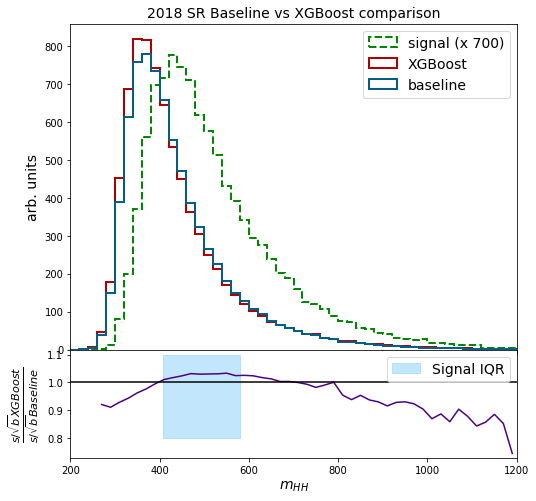

In [247]:
f, ax = plt.subplots(
    2, 1, figsize=(8, 8), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
)

mask_4b = sig18["ntag"] >= 4
mask_sr = sig18["kinematic_region"] == 0

L = lumi(18)

h_s, be = np.histogram(
    sig18.loc[mask_4b & mask_sr, "m_hh"].values,
    bins=50,
    range=(200, 1200),
    weights=L * sig18.loc[mask_4b & mask_sr, "mc_sf"],
)

median = median_histogram(h_s, be)
q25 = weighted_histogram_ecdf(h_s,be,25)
q75 = weighted_histogram_ecdf(h_s, be, 75)
x = bin_midpoint(be)

_ = ax[0].hist(
    sig18.loc[(sig18["ntag"] >= 4) & (sig18["kinematic_region"] == 0), "m_hh"].values,
    histtype="step",
    bins=be,
    label="signal (x 700)",
    ls="--",
    lw=2,
    density=False,
    weights=700
    * L
    * sig18.loc[
        (sig18["ntag"] >= 4) & (sig18["kinematic_region"] == 0), "mc_sf"
    ].values,
)


mus = [get_mu(fd18, 18), get_mu(fdb18, 18)]
hbs = []
labels = ["XGBoost", "baseline"]
for _df, l, mu in zip([data18, data_b18], labels, mus):
    mask_2b = _df["ntag"] == 2
    mask_sr = _df["kinematic_region"] == 0
    w_name = w_col(18)

    h_b, _, _ = ax[0].hist(
        _df.loc[mask_2b & mask_sr, "m_hh"].values,
        bins=be,
        weights=mu * _df.loc[mask_2b & mask_sr, w_name].values,
        histtype="step",
        lw=2,
        label=l,
        density=False,
    )
    hbs.append(h_s / np.sqrt(h_b))
    # ax[1].plot(x, h_s / np.sqrt(h_b), marker=".", linewidth=0, label=l)

ax[1].plot(x, hbs[0] / hbs[1], color='indigo')
ax[1].axhline(1, color="black")
ax[1].fill_betweenx(
    np.linspace(0.8, 1.1, 20),
    q25,
    q75,
    color="lightskyblue",
    alpha=0.5,
    label = 'Signal IQR'
)
ax[0].legend(fontsize=14)
ax[1].legend(loc = 'upper right',fontsize=14)
plt.subplots_adjust(hspace=0)
ax[0].set_xlim(200, 1200)
ax[1].set_ylabel(r"$\frac{s/\sqrt{b} XGBoost}{s/\sqrt{b} Baseline}$", fontsize=16)

ax[1].set_xlabel(r"$m_{HH}$", fontsize = 14)
ax[0].set_ylabel("arb. units", fontsize = 14)
ax[0].set_title('2018 SR Baseline vs XGBoost comparison', fontsize = 14)

In [220]:
from eda_tools.bkg_helper import shape_variations_inclusive2

# Shape Systematics Baseline

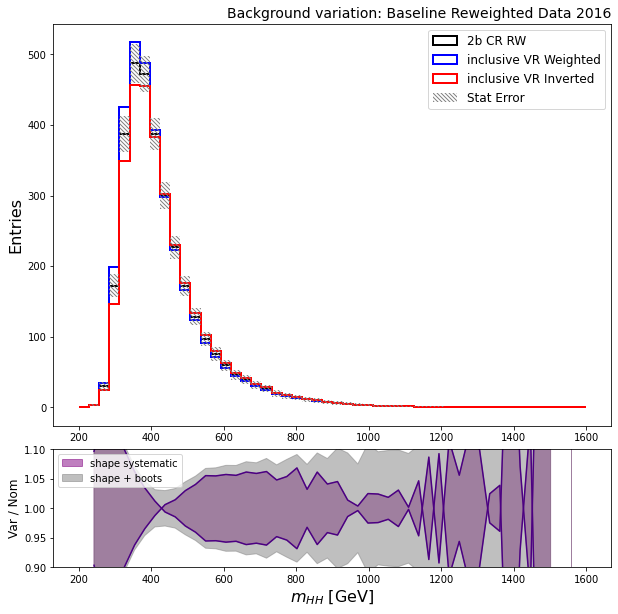

In [465]:
shape_b16  = shape_variations_inclusive2(
    data_b16,
    feature='m_hh',
    ylims=(0.9, 1.1),
    CR_weights=w_col(16),
    VR_weights=w_col(16, True),
    muQCDCR=get_mu(fdb16, 16),
    muQCDVR=get_mu(fdb16, 16, True),
    bs_dict=bs_dict_b16,
    title="Baseline Reweighted Data 2016",
)

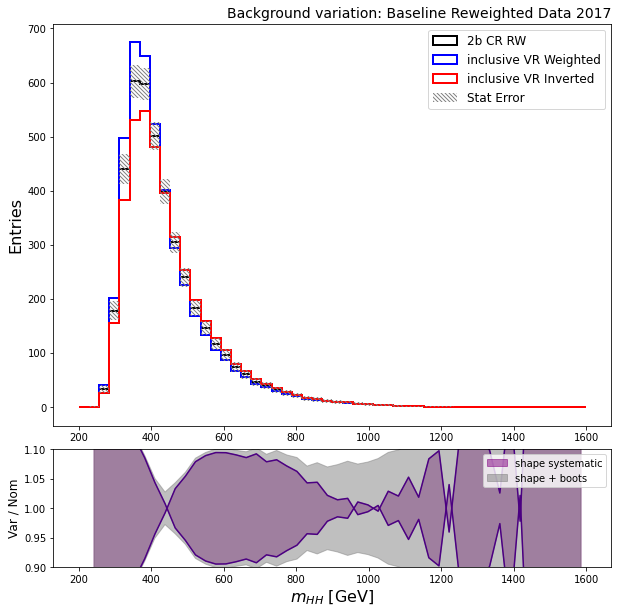

In [466]:
shape_b17  = shape_variations_inclusive2(
    data_b17,
    feature = 'm_hh',
    ylims=(0.9, 1.1),
    CR_weights=w_col(17),
    VR_weights=w_col(17, True),
    muQCDCR=get_mu(fdb17, 17),
    muQCDVR=get_mu(fdb17, 17, True),
    bs_dict=bs_dict_b17,
    title="Baseline Reweighted Data 2017",
)

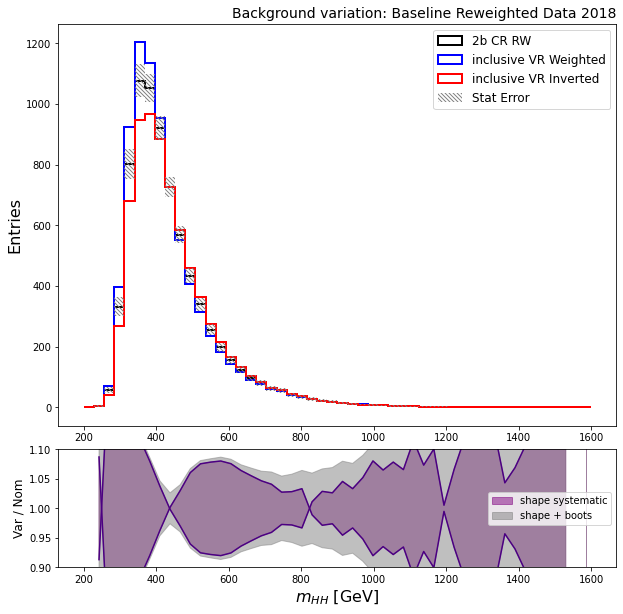

In [467]:
shape_b18  = shape_variations_inclusive2(
    data_b18,
    feature='m_hh',
    ylims=(0.9, 1.1),
    CR_weights=w_col(18),
    VR_weights=w_col(18, True),
    muQCDCR=get_mu(fdb18, 18),
    muQCDVR=get_mu(fdb18, 18, True),
    bs_dict=bs_dict_b18,
    title="Baseline Reweighted Data 2018",
)

# Shape Systematic XGBoost

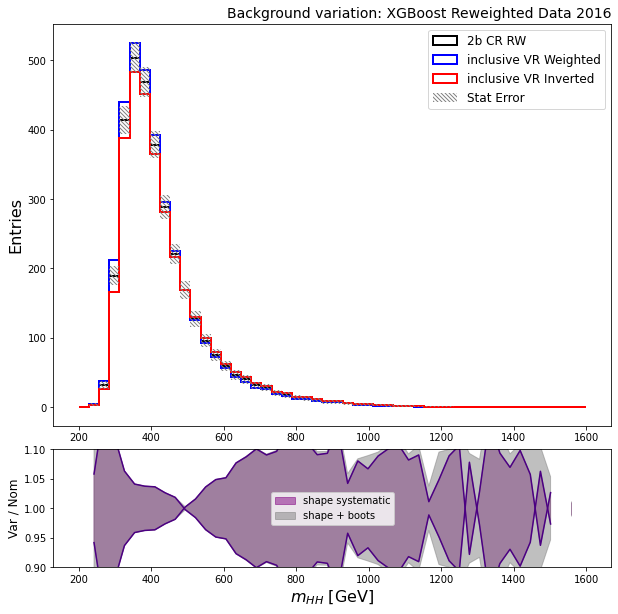

In [468]:
shape16  = shape_variations_inclusive2(
    data16,
    feature = 'm_hh',
    ylims=(0.9, 1.1),
    CR_weights=w_col(16),
    VR_weights=w_col(16, True),
    muQCDCR=get_mu(fd16, 16),
    muQCDVR=get_mu(fd16, 16, True),
    bs_dict=bs_dict16,
    title="XGBoost Reweighted Data 2016",
)

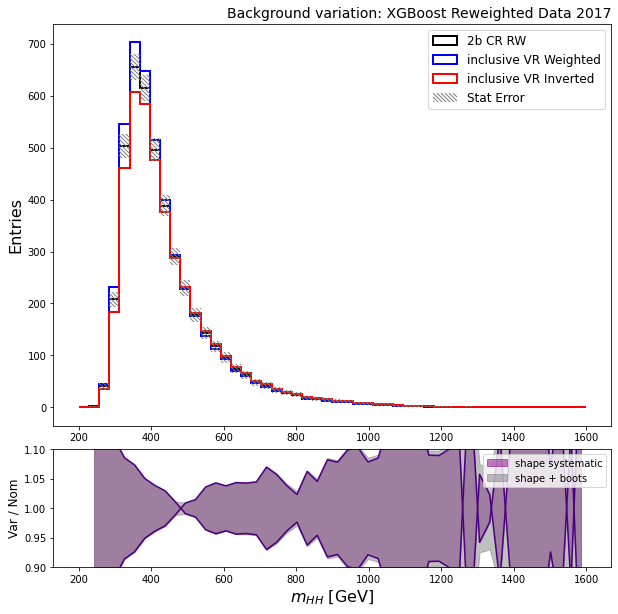

In [469]:
shape17  = shape_variations_inclusive2(
    data17,
    feature = 'm_hh',
    ylims=(0.9, 1.1),
    CR_weights=w_col(17),
    VR_weights=w_col(17, True),
    muQCDCR=get_mu(fd17, 17),
    muQCDVR=get_mu(fd17, 17, True),
    bs_dict=bs_dict17,
    title="XGBoost Reweighted Data 2017",
)

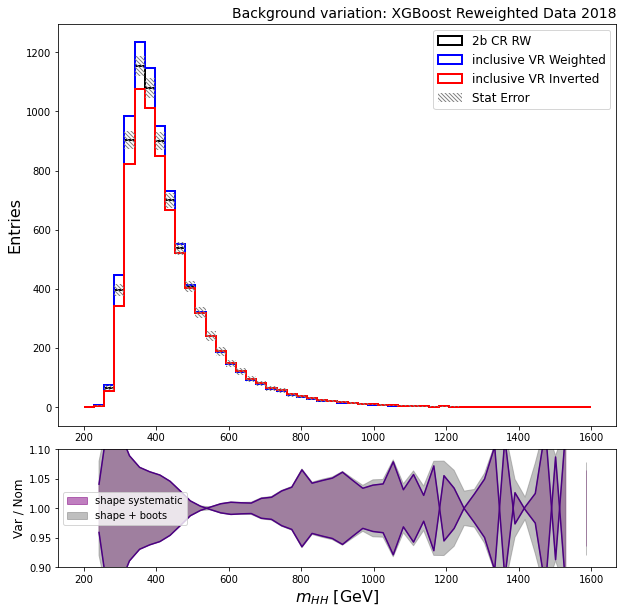

In [470]:
shape18  = shape_variations_inclusive2(
    data18,
    feature='m_hh',
    ylims=(0.9, 1.1),
    CR_weights=w_col(18),
    VR_weights=w_col(18, True),
    muQCDCR=get_mu(fd18, 18),
    muQCDVR=get_mu(fd18, 18, True),
    bs_dict=bs_dict18,
    title="XGBoost Reweighted Data 2018",
)

## Shape Systematics comparison

### Shape systematics only comparison

In [471]:
def shape_systs_comparison(
    shape1: dict, shape2: dict, label1="l1", label2="l2", title='default', xlabel="$m_{HH}$ [GeV]"
):
    x1 = bin_midpoint(shape1["bins"])
    s1_up = shape1["vr"] / shape1["cr"]
    s1_down = shape1["inv"] / shape1["cr"]

    x2 = bin_midpoint(shape2["bins"])
    s2_up = shape2["vr"] / shape2["cr"]
    s2_down = shape2["inv"] / shape2["cr"]

    f, ax = plt.subplots(figsize=(10, 6))

    ax.plot(x1, s1_up, "r-", label=label1)
    ax.plot(x1, s1_down, "r-")

    ax.plot(x2, s2_up, "g-", label=label2)
    ax.plot(x2, s2_down)

    ax.legend(fontsize=14)
    ax.set_ylim(0.8, 1.2)
    ax.set_xlabel(xlabel, fontsize =14)
    ax.set_ylabel("Var / Nom", fontsize=14)
    ax.set_title(title)

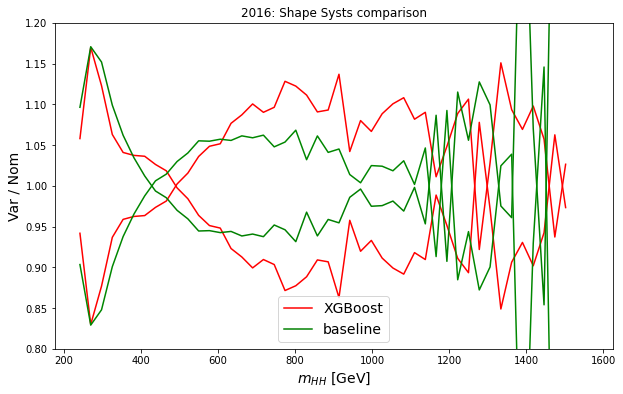

In [472]:
shape_systs_comparison(shape16, shape_b16, label1="XGBoost", label2="baseline", title = '2016: Shape Systs comparison')

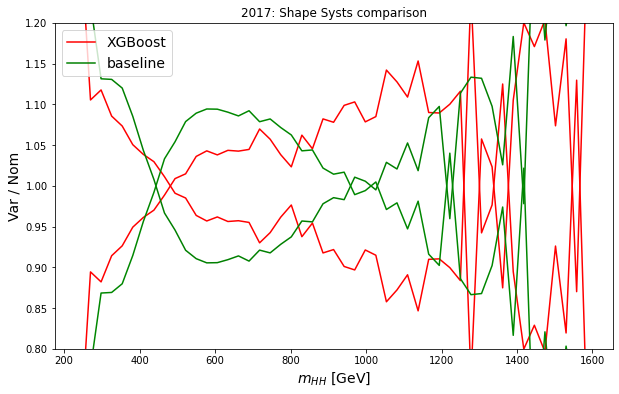

In [473]:
shape_systs_comparison(shape17, shape_b17, label1="XGBoost", label2="baseline", title = '2017: Shape Systs comparison')

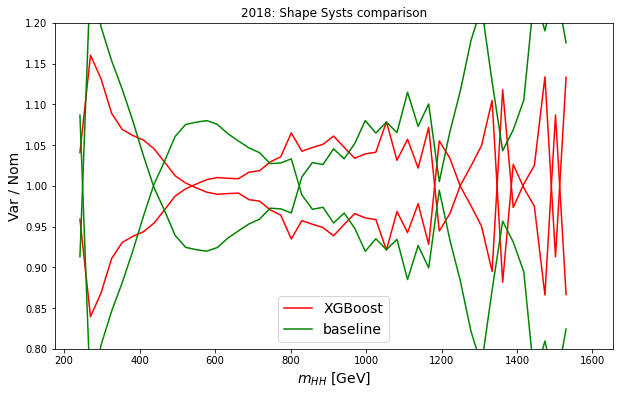

In [474]:
shape_systs_comparison(shape18, shape_b18, label1="XGBoost", label2="baseline", title = '2018: Shape Systs comparison')

## Total Error comparison

In [475]:
def total_error_comparison(
    shape1: dict, shape2: dict, label1="l1", label2="l2", title='default', xlabel="$m_{HH}$ [GeV]"
):
    x1 = bin_midpoint(shape1["bins"])
    s1_up = (shape1['err_bkg'] + shape1['cr']) / shape1['cr']
    s1_down = (shape1["cr"] - shape1['err_bkg']) / shape1["cr"]

    x2 = bin_midpoint(shape2["bins"])
    s2_up = (shape2['err_bkg'] + shape2['cr']) / shape2['cr']
    s2_down = (shape2["cr"] - shape2['err_bkg']) / shape2["cr"]

    f, ax = plt.subplots(figsize=(10, 6))

    ax.plot(x1, s1_up, "r-", label=label1)
    ax.plot(x1, s1_down, "r-")

    ax.plot(x2, s2_up, "g-", label=label2)
    ax.plot(x2, s2_down)

    ax.legend(fontsize=14)
    ax.set_ylim(0.8, 1.2)
    ax.set_xlabel(xlabel, fontsize =14)
    ax.set_ylabel("Var / Nom", fontsize=14)
    ax.set_title(title)

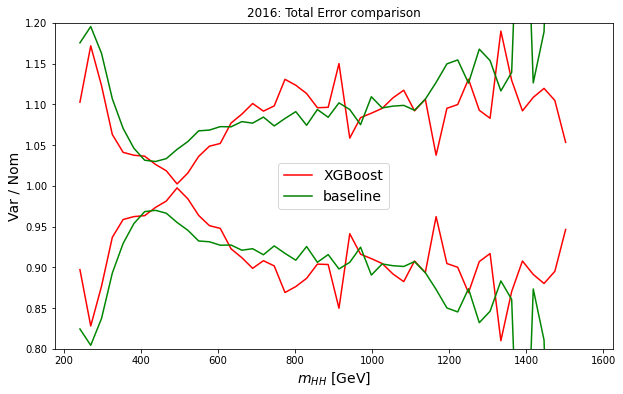

In [476]:
total_error_comparison(shape16, shape_b16,label1="XGBoost", label2="baseline", title = '2016: Total Error comparison')

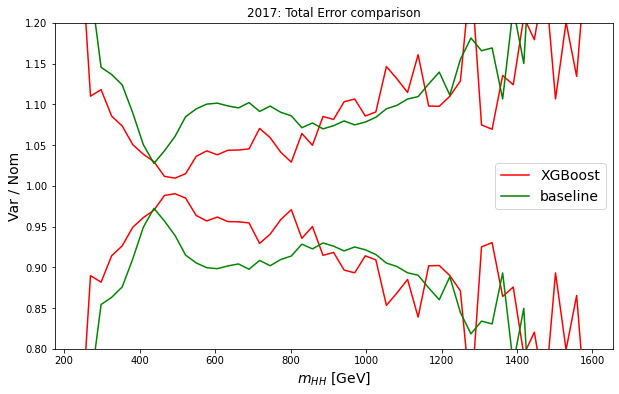

In [477]:
total_error_comparison(shape17, shape_b17,label1="XGBoost", label2="baseline", title = '2017: Total Error comparison')

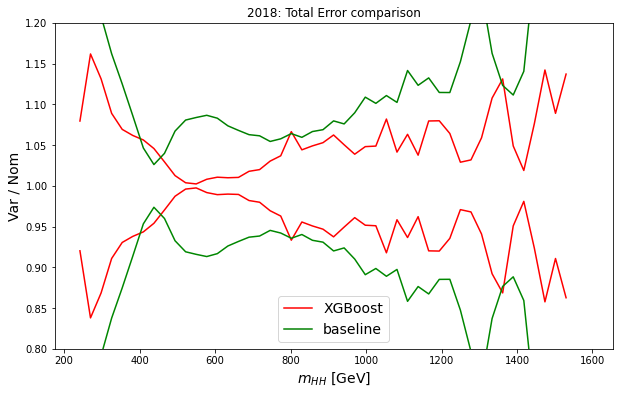

In [478]:
total_error_comparison(shape18, shape_b18,label1="XGBoost", label2="baseline", title = '2018: Total Error comparison')

# Analysis of weights

**This will have to be done elsewhere so that we can load all of the weights for xgboost for each bootstrap fold**

In [39]:
data16['NN_d24_weight_bstrap_IQR_16'].mean()

0.0013599233349652334

In [43]:
fp16

'/mnt/storage/lborgna/NNT/MDR_VEC/data/xgboost/data_MDR_VEC_16_with_weights.root'

In [44]:
help(get_mu)

Help on function get_mu in module __main__:

get_mu(file, year:int=16, vr:bool=False) -> float



In [46]:
fd16.keys()

[b'validation;1',
 b'sig;1',
 b'control;1',
 b'NN_norm_bstrap_med_16;1',
 b'NN_norm_bstrap_IQR_16;1',
 b'NN_norm_bstrap_perc_25_16;1',
 b'NN_norm_bstrap_perc_75_16;1',
 b'NN_norm_VRderiv_bstrap_med_16;1',
 b'NN_norm_VRderiv_bstrap_IQR_16;1',
 b'NN_norm_VRderiv_bstrap_perc_25_16;1',
 b'NN_norm_VRderiv_bstrap_perc_75_16;1']

In [48]:
get_mu(fd16, 16)

1.0083747507007308

In [49]:
get_mu(fd16, 16, vr=True)

1.013192499194812

In [50]:
get_mu_iqr(fd16, 16)

0.0013814190607830401

In [59]:
get_mu_iqr(fdb16, 16)

0.07445350070911216

In [51]:
get_mu_iqr(fd16, 16, vr=True)

0.0022232174512109015

In [62]:
get_mu_iqr(fdb16, 16, vr=True)

0.07990130972042442

In [64]:
get_mu_iqr(fd17, 17)

0.001420041120186788

In [63]:
get_mu_iqr(fdb17, 17)

0.06777442132838918

## Reweighted Hist

In [414]:
from eda_tools.bkg_helper import  reweightedHist

In [415]:
help(reweightedHist)

Help on function reweightedHist in module eda_tools.bkg_helper:

reweightedHist(df, kinematic_region=2, feature='m_hh_cor', bins=50, hrange=(200, 1400), figsize=(8, 8), weighted=True, w=None, filename=None, bootstrap=None, muQCD=None, xlabel=None, weight_column='w_2b', histtype='step', color='darkorange', linewidth=2, norm=1, display=False, title='default', pull='atlas', pull_fit=False, density=True, show_stats=True)



this is my poisson error


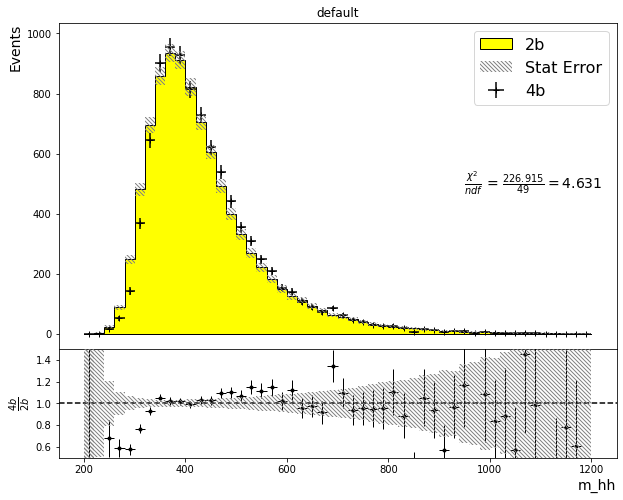

In [420]:
test = reweightedHist(
    data16,
    kinematic_region=2,
    feature="m_hh",
    bins=50,
    hrange=(200, 1200),
    figsize=(10, 8),
    bootstrap=bs_dict16,
    density= False,
    muQCD=get_mu(fd16, 16),
    weight_column=w_col(16),
    pull=None,
)

In [419]:
list(test['poisson_error'])

[5.466471825251406,
 8.663160272360852,
 12.813852739414607,
 17.106318186489734,
 20.68129818197716,
 23.20893190007249,
 25.150512599352496,
 26.155097212504582,
 26.55264585782881,
 26.111026060150103,
 24.97847978935939,
 23.749910710858625,
 22.41090572762662,
 21.06041519827034,
 19.426460216332547,
 18.049372320391637,
 16.67414301870466,
 15.584216663516909,
 14.377811490696724,
 13.358445513887231,
 12.532054780216663,
 11.518376517985612,
 10.702994807104346,
 10.213801684708258,
 9.403511692132588,
 9.056366297429523,
 8.403539057533415,
 7.900357501908925,
 7.442891044672844,
 6.758897665279148,
 6.626343057857297,
 6.291291718473486,
 5.806896605196957,
 5.48867431948905,
 5.118201042797916,
 4.567390881768558,
 4.2938550667500115,
 4.339890066481397,
 4.093149817449708,
 3.968404016061627,
 3.5090500699716856,
 3.359003674777229,
 3.1745968264078495,
 3.113854130731014,
 2.681274091120092,
 2.959303872180242,
 2.430497543954081,
 2.3959171941078687,
 2.0430017865830923,
 

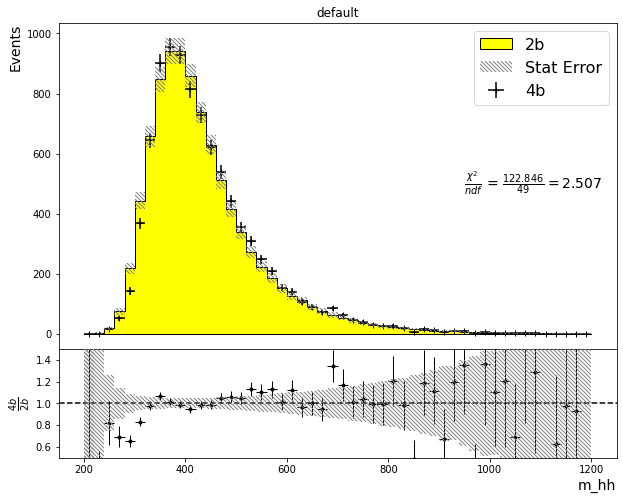

In [411]:
test = reweightedHist(
    data_b16,
    kinematic_region=2,
    feature="m_hh",
    bins=50,
    hrange=(200, 1200),
    figsize=(10, 8),
    bootstrap=bs_dict_b16,
    density= False,
    muQCD=get_mu(fdb16, 16),
    weight_column=w_col(16),
    pull=None
)

In [ ]:
### test

# VR estimate

Let's compare the CR model in the VR between baseline and xgboost

Text(0.5, 1.0, 'Data 2016: Validation region CR derived model')

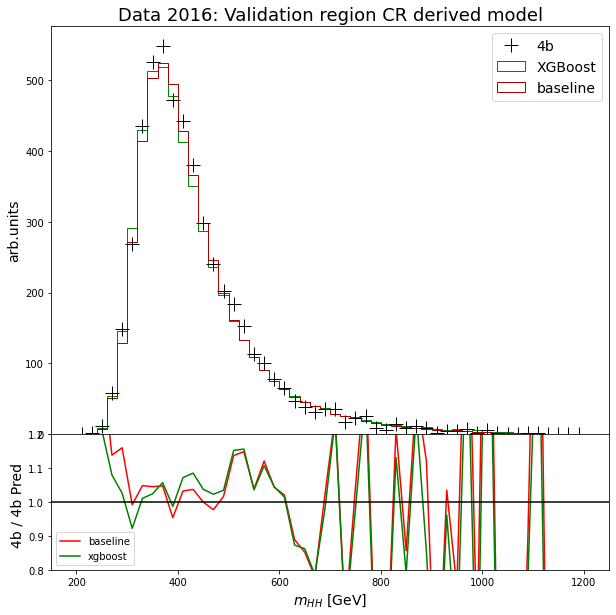

In [515]:
f, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True,gridspec_kw={"height_ratios":[3,1]})

mask_4b = data16["ntag"] >= 4
mask_vr = data16["kinematic_region"] == 1
h_s, be = np.histogram(
    data16.loc[mask_4b & mask_vr, "m_hh"], bins=50, range=(200, 1200)
)
x = bin_midpoint(be)

ax[0].plot(x, h_s, "+", color="black", markersize=14, label="4b")

###XGboost
h_xgb, _, _ = ax[0].hist(
    data16.loc[
        (data16["ntag"] == 2) & (data16["kinematic_region"] == 1), "m_hh"
    ].values,
    bins=be,
    histtype="step",
    label="XGBoost",
    weights=get_mu(fd16, 16)
    * data16.loc[
        (data16["ntag"] == 2) & (data16["kinematic_region"] == 1), w_col(16)
    ].values,
)
###Baseline
h_base, _, _ = ax[0].hist(
    data_b16.loc[
        (data_b16["ntag"] == 2) & (data_b16["kinematic_region"] == 1), "m_hh"
    ].values,
    bins=be,
    histtype="step",
    label="baseline",
    weights=get_mu(fdb16, 16)
    * data_b16.loc[
        (data_b16["ntag"] == 2) & (data_b16["kinematic_region"] == 1), w_col(16)
    ].values,
)

ax[0].legend(fontsize=14)
ax[1].plot(x, h_s / h_base, label="baseline", color='red')
ax[1].plot(x, h_s / h_xgb, label="xgboost", color='green')
ax[1].legend()
plt.subplots_adjust(hspace=0)
ax[1].set_ylim(0.8, 1.2)
ax[1].axhline(1, color="black")
ax[1].set_xlabel("$m_{HH}$ [GeV]", fontsize = 14)
ax[1].set_ylabel("4b / 4b Pred ", fontsize = 14)
ax[0].set_ylabel('arb.units', fontsize=14)
ax[0].set_title('Data 2016: Validation region CR derived model', fontsize = 18)

Text(0.5, 1.0, 'Data 2017: Validation region CR derived model')

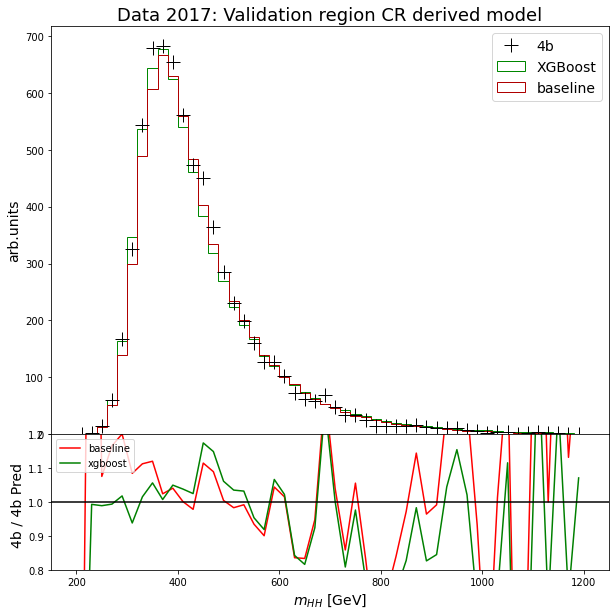

In [516]:
f, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True,gridspec_kw={"height_ratios":[3,1]})

mask_4b = data17["ntag"] >= 4
mask_vr = data17["kinematic_region"] == 1
h_s, be = np.histogram(
    data17.loc[mask_4b & mask_vr, "m_hh"], bins=50, range=(200, 1200)
)
x = bin_midpoint(be)

ax[0].plot(x, h_s, "+", color="black", markersize=14, label="4b")

###XGboost
h_xgb, _, _ = ax[0].hist(
    data17.loc[
        (data17["ntag"] == 2) & (data17["kinematic_region"] == 1), "m_hh"
    ].values,
    bins=be,
    histtype="step",
    label="XGBoost",
    weights=get_mu(fd17, 17)
    * data17.loc[
        (data17["ntag"] == 2) & (data17["kinematic_region"] == 1), w_col(17)
    ].values,
)
###Baseline
h_base, _, _ = ax[0].hist(
    data_b17.loc[
        (data_b17["ntag"] == 2) & (data_b17["kinematic_region"] == 1), "m_hh"
    ].values,
    bins=be,
    histtype="step",
    label="baseline",
    weights=get_mu(fdb17, 17)
    * data_b17.loc[
        (data_b17["ntag"] == 2) & (data_b17["kinematic_region"] == 1), w_col(17)
    ].values,
)

ax[0].legend(fontsize=14)

ax[1].plot(x, h_s / h_base, label="baseline", color='red')
ax[1].plot(x, h_s / h_xgb, label="xgboost", color='green')
ax[1].legend()
plt.subplots_adjust(hspace=0)
ax[1].set_ylim(0.8, 1.2)
ax[1].axhline(1, color="black")
ax[1].set_xlabel("$m_{HH}$ [GeV]", fontsize = 14)
ax[1].set_ylabel("4b / 4b Pred ", fontsize = 14)
ax[0].set_ylabel('arb.units', fontsize=14)
ax[0].set_title('Data 2017: Validation region CR derived model', fontsize = 18)

Text(0.5, 1.0, 'Data 2018: Validation region CR derived model')

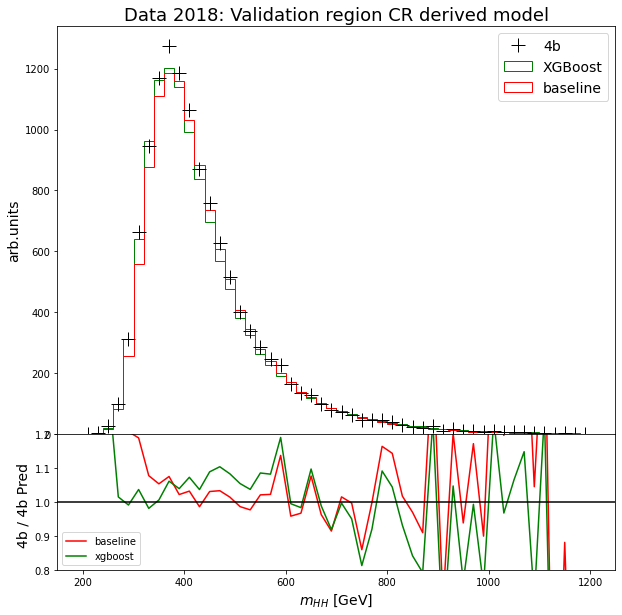

In [522]:
f, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True,gridspec_kw={"height_ratios":[3,1]})

mask_4b = data18["ntag"] >= 4
mask_vr = data18["kinematic_region"] == 1
h_s, be = np.histogram(
    data18.loc[mask_4b & mask_vr, "m_hh"], bins=50, range=(200, 1200)
)
x = bin_midpoint(be)

ax[0].plot(x, h_s, "+", color="black", markersize=14, label="4b")

###XGboost
h_xgb, _, _ = ax[0].hist(
    data18.loc[
        (data18["ntag"] == 2) & (data18["kinematic_region"] == 1), "m_hh"
    ].values,
    bins=be,
    histtype="step",
    label="XGBoost",
    color ='green',
    weights=get_mu(fd18, 18)
    * data18.loc[
        (data18["ntag"] == 2) & (data18["kinematic_region"] == 1), w_col(18)
    ].values,
)
###Baseline
h_base, _, _ = ax[0].hist(
    data_b18.loc[
        (data_b18["ntag"] == 2) & (data_b18["kinematic_region"] == 1), "m_hh"
    ].values,
    bins=be,
    histtype="step",
    label="baseline",
    color='red',
    weights=get_mu(fdb18, 18)
    * data_b18.loc[
        (data_b18["ntag"] == 2) & (data_b18["kinematic_region"] == 1), w_col(18)
    ].values,
)

ax[0].legend(fontsize=14)

ax[1].plot(x, h_s / h_base, label="baseline", color='red')
ax[1].plot(x, h_s / h_xgb, label="xgboost", color='green')
ax[1].legend()
plt.subplots_adjust(hspace=0)
ax[1].set_ylim(0.8, 1.2)
ax[1].axhline(1, color="black")
ax[1].set_xlabel("$m_{HH}$ [GeV]", fontsize = 14)
ax[1].set_ylabel("4b / 4b Pred ", fontsize = 14)
ax[0].set_ylabel('arb.units', fontsize=14)
ax[0].set_title('Data 2018: Validation region CR derived model', fontsize = 18)

## VR estimate VR derived model

Text(0.5, 1.0, 'Data 2016: Validation region VR derived model')

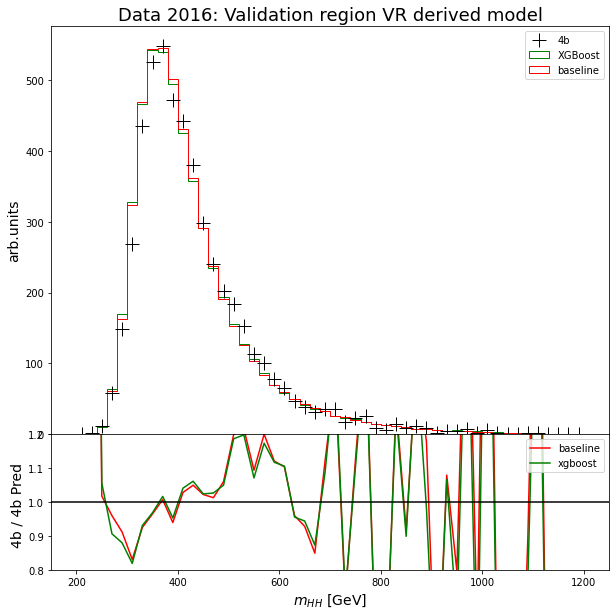

In [518]:
f, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True,gridspec_kw={"height_ratios":[3,1]})

mask_4b = data16["ntag"] >= 4
mask_vr = data16["kinematic_region"] == 1
h_s, be = np.histogram(
    data16.loc[mask_4b & mask_vr, "m_hh"], bins=50, range=(200, 1200)
)
x = bin_midpoint(be)

ax[0].plot(x, h_s, "+", color="black", markersize=14, label="4b")

###XGboost
h_xgb, _, _ = ax[0].hist(
    data16.loc[
        (data16["ntag"] == 2) & (data16["kinematic_region"] == 1), "m_hh"
    ].values,
    bins=be,
    histtype="step",
    label="XGBoost",
    color='green',
    weights=get_mu(fd16, 16, vr=True)
    * data16.loc[
        (data16["ntag"] == 2) & (data16["kinematic_region"] == 1), w_col(16,vr=True)
    ].values,
)
###Baseline
h_base, _, _ = ax[0].hist(
    data_b16.loc[
        (data_b16["ntag"] == 2) & (data_b16["kinematic_region"] == 1), "m_hh"
    ].values,
    bins=be,
    histtype="step",
    label="baseline",
    color='red',
    weights=get_mu(fdb16, 16, vr=True)
    * data_b16.loc[
        (data_b16["ntag"] == 2) & (data_b16["kinematic_region"] == 1), w_col(16, vr=True)
    ].values,
)

ax[0].legend()

ax[1].plot(x, h_s / h_base, label="baseline", color='red')
ax[1].plot(x, h_s / h_xgb, label="xgboost", color='green')
ax[1].legend()
plt.subplots_adjust(hspace=0)
ax[1].set_ylim(0.8, 1.2)
ax[1].axhline(1, color="black")
ax[1].set_xlabel("$m_{HH}$ [GeV]", fontsize = 14)
ax[1].set_ylabel("4b / 4b Pred ", fontsize = 14)
ax[0].set_ylabel('arb.units', fontsize=14)
ax[0].set_title('Data 2016: Validation region VR derived model', fontsize = 18)

Text(0.5, 1.0, 'Data 2017: Validation region VR derived model')

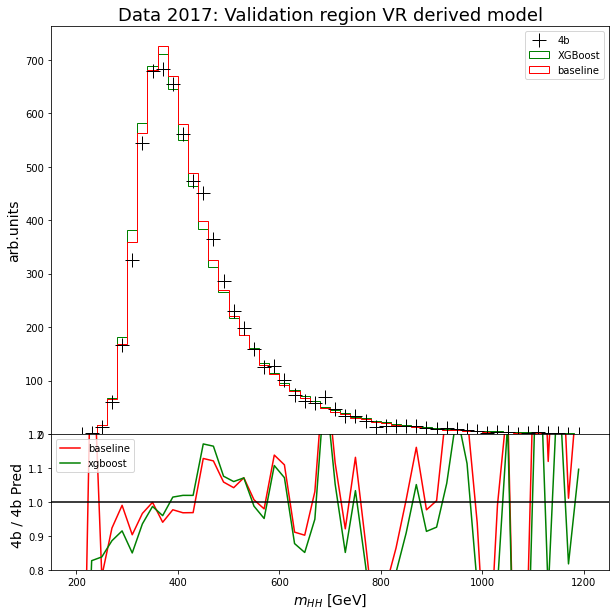

In [519]:
f, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True,gridspec_kw={"height_ratios":[3,1]})

mask_4b = data17["ntag"] >= 4
mask_vr = data17["kinematic_region"] == 1
h_s, be = np.histogram(
    data17.loc[mask_4b & mask_vr, "m_hh"], bins=50, range=(200, 1200)
)
x = bin_midpoint(be)

ax[0].plot(x, h_s, "+", color="black", markersize=14, label="4b")

###XGboost
h_xgb, _, _ = ax[0].hist(
    data17.loc[
        (data17["ntag"] == 2) & (data17["kinematic_region"] == 1), "m_hh"
    ].values,
    bins=be,
    histtype="step",
    label="XGBoost",
    color='green',
    weights=get_mu(fd17, 17, vr=True)
    * data17.loc[
        (data17["ntag"] == 2) & (data17["kinematic_region"] == 1), w_col(17,vr=True)
    ].values,
)
###Baseline
h_base, _, _ = ax[0].hist(
    data_b17.loc[
        (data_b17["ntag"] == 2) & (data_b17["kinematic_region"] == 1), "m_hh"
    ].values,
    bins=be,
    histtype="step",
    label="baseline",
    color='red',
    weights=get_mu(fdb17, 17, vr=True)
    * data_b17.loc[
        (data_b17["ntag"] == 2) & (data_b17["kinematic_region"] == 1), w_col(17, vr=True)
    ].values,
)

ax[0].legend()

ax[1].plot(x, h_s / h_base, label="baseline", color='red')
ax[1].plot(x, h_s / h_xgb, label="xgboost", color='green')
ax[1].legend()
plt.subplots_adjust(hspace=0)
ax[1].set_ylim(0.8, 1.2)
ax[1].axhline(1, color="black")
ax[1].set_xlabel("$m_{HH}$ [GeV]", fontsize = 14)
ax[1].set_ylabel("4b / 4b Pred ", fontsize = 14)
ax[0].set_ylabel('arb.units', fontsize=14)
ax[0].set_title('Data 2017: Validation region VR derived model', fontsize = 18)

Text(0.5, 1.0, 'Data 2018: Validation region VR derived model')

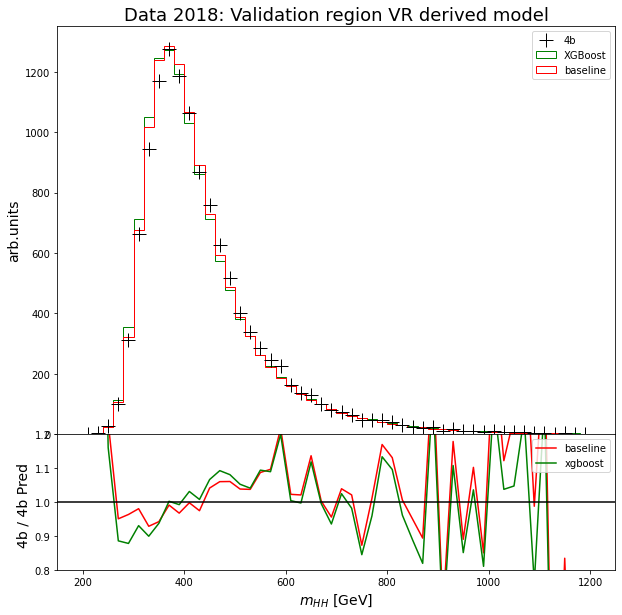

In [520]:
f, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True,gridspec_kw={"height_ratios":[3,1]})

mask_4b = data18["ntag"] >= 4
mask_vr = data18["kinematic_region"] == 1
h_s, be = np.histogram(
    data18.loc[mask_4b & mask_vr, "m_hh"], bins=50, range=(200, 1200)
)
x = bin_midpoint(be)

ax[0].plot(x, h_s, "+", color="black", markersize=14, label="4b")

###XGboost
h_xgb, _, _ = ax[0].hist(
    data18.loc[
        (data18["ntag"] == 2) & (data18["kinematic_region"] == 1), "m_hh"
    ].values,
    bins=be,
    histtype="step",
    label="XGBoost",
    color='green',
    weights=get_mu(fd18, 18, vr=True)
    * data18.loc[
        (data18["ntag"] == 2) & (data18["kinematic_region"] == 1), w_col(18,vr=True)
    ].values,
)
###Baseline
h_base, _, _ = ax[0].hist(
    data_b18.loc[
        (data_b18["ntag"] == 2) & (data_b18["kinematic_region"] == 1), "m_hh"
    ].values,
    bins=be,
    histtype="step",
    label="baseline",
    color='red',
    weights=get_mu(fdb18, 18, vr=True)
    * data_b18.loc[
        (data_b18["ntag"] == 2) & (data_b18["kinematic_region"] == 1), w_col(18, vr=True)
    ].values,
)

ax[0].legend()

ax[1].plot(x, h_s / h_base, label="baseline", color='red')
ax[1].plot(x, h_s / h_xgb, label="xgboost", color='green')
ax[1].legend()
plt.subplots_adjust(hspace=0)
ax[1].set_ylim(0.8, 1.2)
ax[1].axhline(1, color="black")
ax[1].set_xlabel("$m_{HH}$ [GeV]", fontsize = 14)
ax[1].set_ylabel("4b / 4b Pred ", fontsize = 14)
ax[0].set_ylabel('arb.units', fontsize=14)
ax[0].set_title('Data 2018: Validation region VR derived model', fontsize = 18)

# Unweighting Features

In [521]:
from eda_tools.bkg_helper import unweightedHist

In [307]:
help(unweightedHist)

Help on function unweightedHist in module eda_tools.bkg_helper:

unweightedHist(df, kinematic_region=2, feature='m_hh_cor', bins=50, hrange=(200, 1400), figsize=(8, 8), filename=None, xlabel=None, histtype='step', color='darkorange', linewidth=2, display=False, title='default', pull='atlas', show_stats=True)



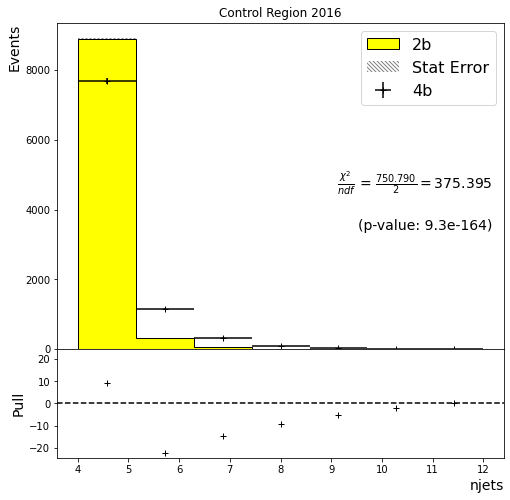

In [331]:
_ = unweightedHist(
    data16,
    kinematic_region=2,
    feature="njets",
    bins=7,
    hrange=(4, 12),
    title="Control Region 2016",
)

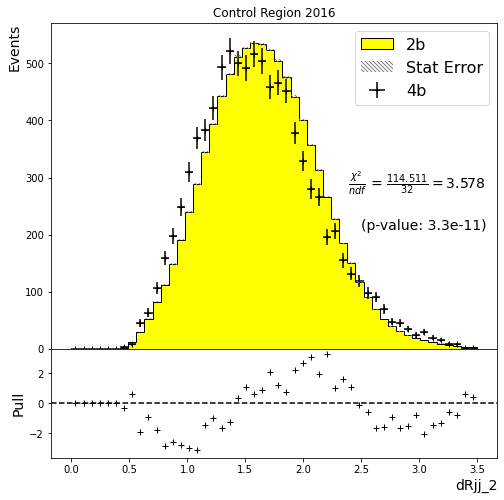

In [332]:
_ = unweightedHist(
    data16,
    kinematic_region=2,
    feature="dRjj_2",
    bins=50,
    hrange=(0, 3.5),
    title="Control Region 2016",
)

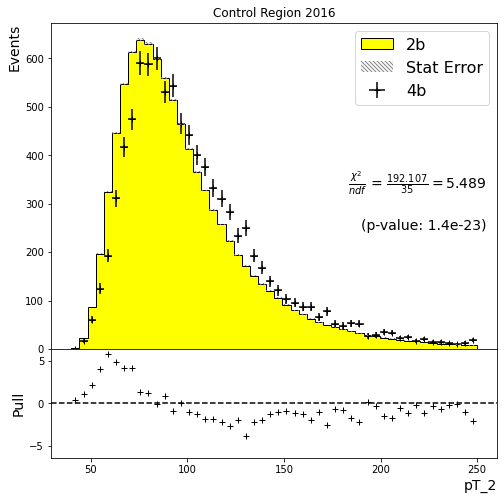

In [333]:
_ = unweightedHist(
    data16,
    kinematic_region=2,
    feature="pT_2",
    bins=50,
    hrange=(40, 250),
    title="Control Region 2016",
)

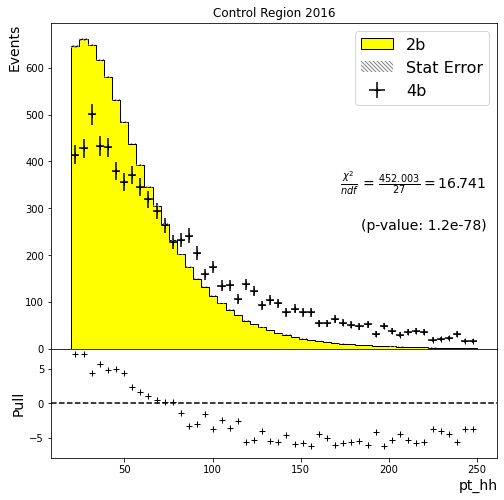

In [334]:
_ = unweightedHist(
    data16,
    kinematic_region=2,
    feature="pt_hh",
    bins=50,
    hrange=(20, 250),
    title="Control Region 2016",
)

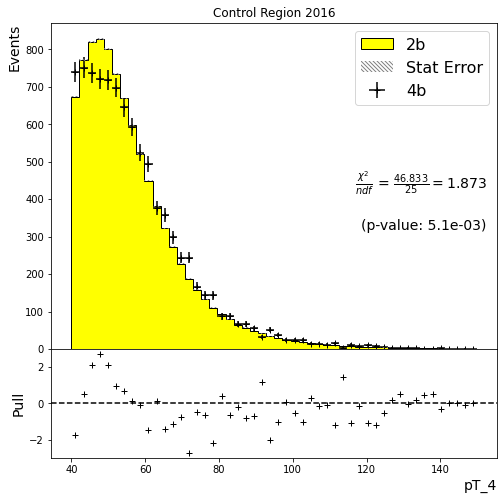

In [335]:
_ = unweightedHist(
    data16,
    kinematic_region=2,
    feature="pT_4",
    bins=50,
    hrange=(40, 150),
    title="Control Region 2016",
)

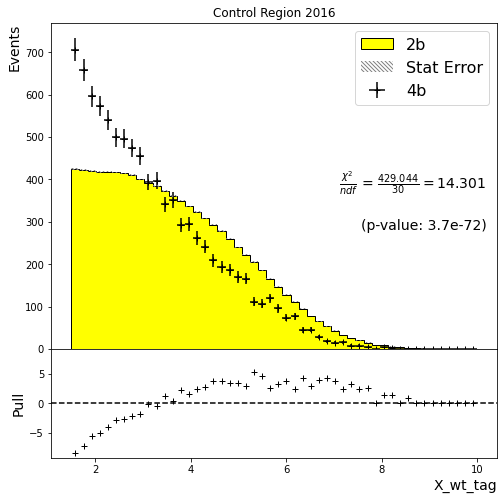

In [336]:
_ = unweightedHist(
    data16,
    kinematic_region=2,
    feature="X_wt_tag",
    bins=50,
    hrange=(1.5, 10),
    title="Control Region 2016",
)

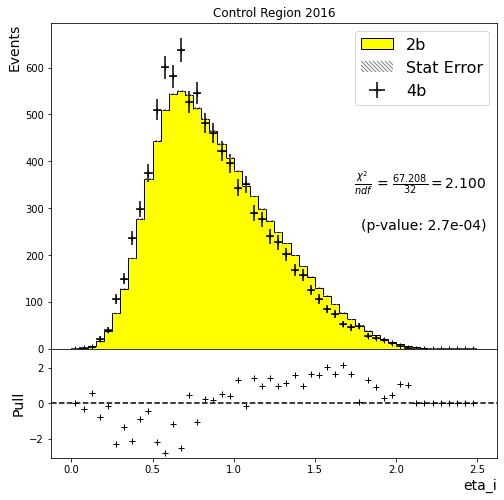

In [337]:
_ = unweightedHist(
    data16,
    kinematic_region=2,
    feature="eta_i",
    bins=50,
    hrange=(0,2.5),
    title="Control Region 2016",
)

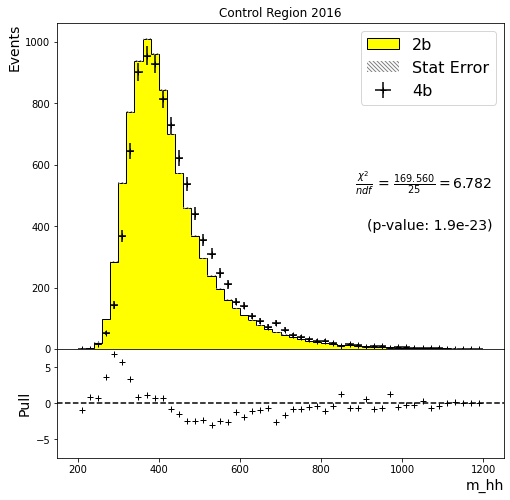

In [338]:
_ = unweightedHist(
    data16,
    kinematic_region=2,
    feature="m_hh",
    bins=50,
    hrange=(200, 1200),
    title="Control Region 2016",
)

# Reweighting of features

In [24]:
from eda_tools.bkg_helper import reweightedHist

In [69]:
help(reweightedHist)

Help on function reweightedHist in module eda_tools.bkg_helper:

reweightedHist(df, kinematic_region=2, feature='m_hh_cor', bins=50, hrange=(200, 1400), figsize=(8, 8), weighted=True, w=None, filename=None, bootstrap=None, muQCD=None, xlabel=None, weight_column='w_2b', histtype='step', color='darkorange', linewidth=2, norm=1, display=False, title='default', pull='atlas', pull_fit=False, density=True, show_stats=True)



**CR Models**

this is my poisson error


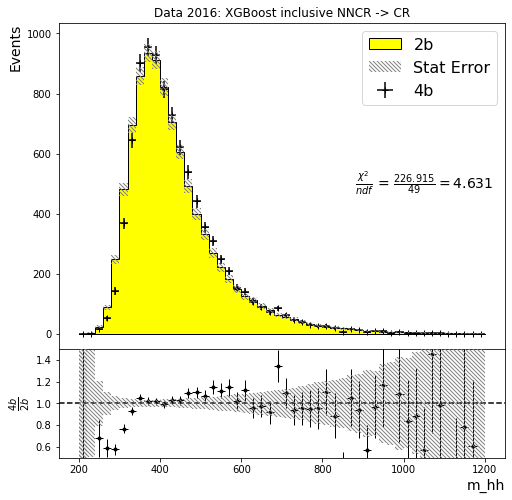

In [492]:
s2_cr = reweightedHist(
    data16,
    kinematic_region=2,
    muQCD=get_mu(fd16, 16),
    weight_column=w_col(16),
    weighted=True,
    density=False,
    bootstrap=bs_dict16,
    feature='m_hh_cor',
    hrange=(200, 1200),
    title="Data 2016: XGBoost inclusive NNCR -> CR",
    pull=None
)

this is my poisson error


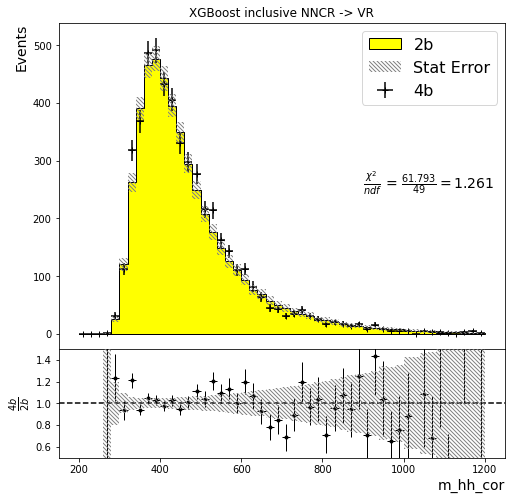

In [487]:
s2_cr = reweightedHist(
    data16,
    kinematic_region=1,
    muQCD=get_mu(fd16, 16),
    weight_column=w_col(16),
    bootstrap=bs_dict16,
    weighted=True,
    density=False,
    feature='m_hh_cor',
    hrange=(200, 1200),
    title="XGBoost inclusive NNCR -> VR",
    pull=None,
)

this is my poisson error


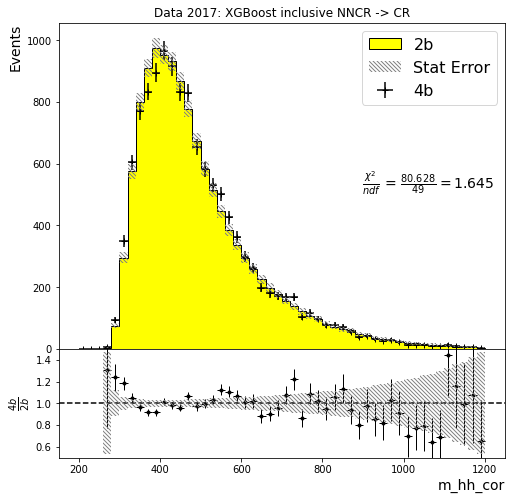

In [488]:
s2_cr = reweightedHist(
    data17,
    kinematic_region=2,
    muQCD=get_mu(fd17, 17),
    weight_column=w_col(17),
    bootstrap=bs_dict17,
    weighted=True,
    density=False,
    feature='m_hh_cor',
    hrange=(200, 1200),
    title="Data 2017: XGBoost inclusive NNCR -> CR",
    pull=None,
)

this is my poisson error


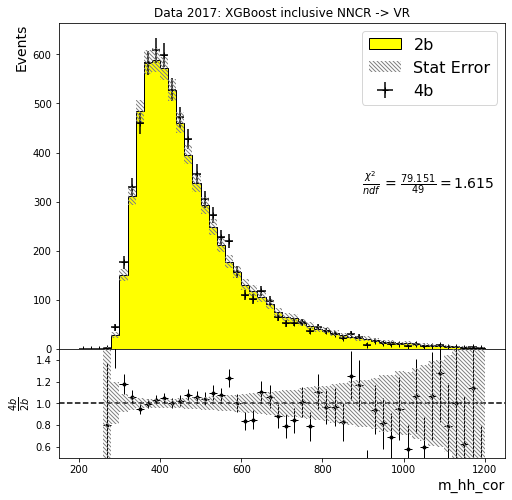

In [489]:
s2_cr = reweightedHist(
    data17,
    kinematic_region=1,
    muQCD=get_mu(fd17, 17),
    weight_column=w_col(17),
    bootstrap=bs_dict17,
    weighted=True,
    density=False,
    feature='m_hh_cor',
    hrange=(200, 1200),
    title="Data 2017: XGBoost inclusive NNCR -> VR",
    pull = None,
)

this is my poisson error


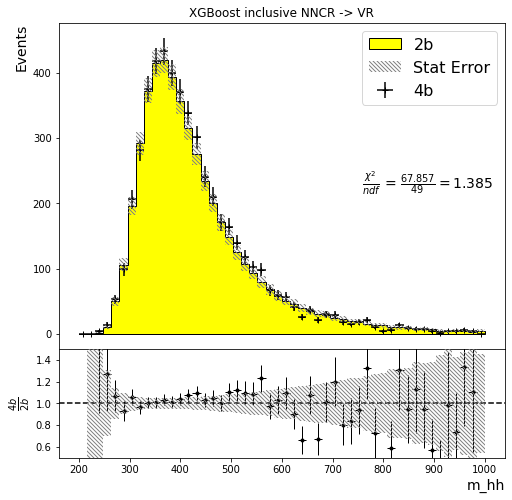

In [490]:
s2_cr = reweightedHist(
    data16,
    kinematic_region=1,
    muQCD=get_mu(fd16, 16),
    weight_column=w_col(16),
    bootstrap=bs_dict16,
    weighted=True,
    density=False,
    feature='m_hh',
    hrange=(200, 1000),
    title="XGBoost inclusive NNCR -> VR",
    pull = None,
)

this is my poisson error


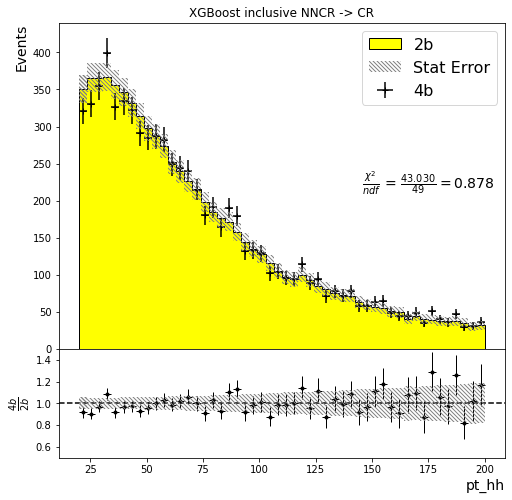

In [495]:
s2_cr = reweightedHist(
    data16,
    kinematic_region=2,
    muQCD=get_mu(fd16, 16),
    weight_column=w_col(16),
    bootstrap=bs_dict16,
    weighted=True,
    density=False,
    feature='pt_hh',
    hrange=(20, 200),
    title="XGBoost inclusive NNCR -> CR",
    pull = None,
)

this is my poisson error


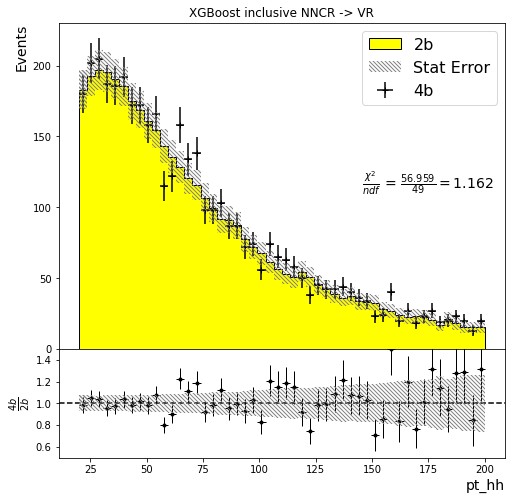

In [496]:
s2_cr = reweightedHist(
    data16,
    kinematic_region=1,
    muQCD=get_mu(fd16, 16),
    weight_column=w_col(16),
    bootstrap=bs_dict16,
    weighted=True,
    density=False,
    feature='pt_hh',
    hrange=(20, 200),
    title="XGBoost inclusive NNCR -> VR",
    pull = None,
)

# Closure Checks

Lets do some comparisons between the Neural Network baseline and the current XGBoost

Comparison will be:
    - XGBOOST_CR * CR_2b = CR_4b
    - NN_CR * CR_2b = CR_4b           

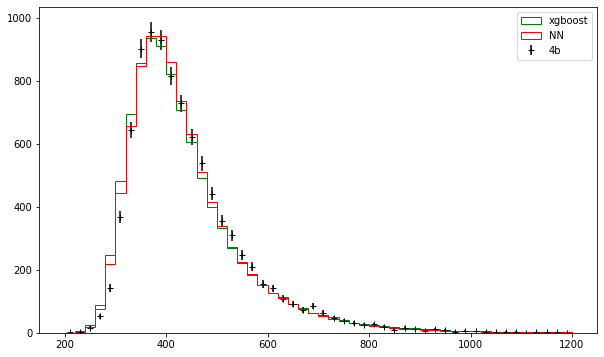

In [639]:
f, ax = plt.subplots(figsize=(10, 6))
mask_4b = data16["ntag"] >= 4
mask_kr = data16["kinematic_region"] == 2

h_4b, be = np.histogram(
    data16.loc[mask_4b & mask_kr, "m_hh"].values, bins=50, range=(200, 1200)
)

h_4b_err = np.sqrt(h_4b)

x = bin_midpoint(be)

ax.errorbar(x, h_4b, yerr=h_4b_err, fmt="k+", label="4b")

mask_2b = data16["ntag"] == 2
mask_kr = data16["kinematic_region"] == 2

h_2b_xgb, _, _ = ax.hist(
    data16.loc[mask_2b & mask_kr, "m_hh"].values,
    bins=be,
    weights=get_mu(fd16, 16) * data16.loc[mask_2b & mask_kr, w_col(16)].values,
    histtype="step",
    label="xgboost",
    color ='green'
)

mask_2b = data_b16['ntag'] == 2
mask_kr = data_b16['kinematic_region'] == 2

h_2b_nn, _, _ = ax.hist(
    data_b16.loc[mask_2b & mask_kr, "m_hh"].values,
    bins=be,
    weights=get_mu(fdb16, 16) * data_b16.loc[mask_2b & mask_kr, w_col(16)].values,
    histtype="step",
    label="NN",
    color = 'red',
)
ax.legend()

Text(0.5, 1.0, 'Control Region Closure\nmodel CR $\\times$ 2b CR = 4b CR ')

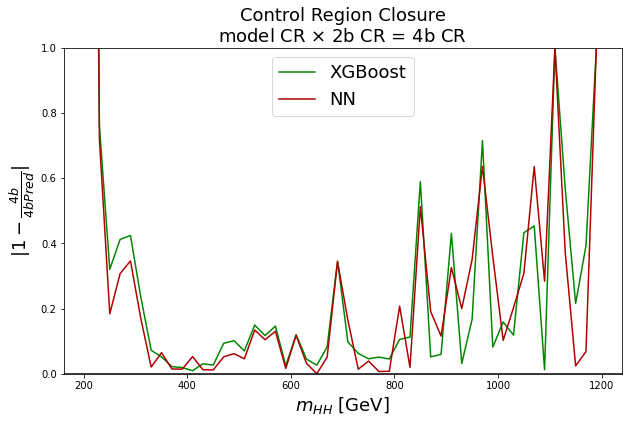

In [640]:
plt.subplots(figsize=(10,6))
plt.plot(x, np.abs(1-(h_4b/h_2b_xgb)), label='XGBoost')
plt.plot(x, np.abs(1-(h_4b/h_2b_nn)), label = 'NN')
plt.axhline(0, color='black')
plt.ylim(0, 1)
plt.legend()
plt.ylabel('$|1-\\frac{4b}{4b Pred}|$', fontsize = 18)
plt.xlabel('$m_{HH}$ [GeV]', fontsize = 18 )
plt.legend(fontsize = 18)
title_str = "Control Region Closure\n"
title_str+= r"model CR $\times$ 2b CR = 4b CR "
plt.title(title_str, fontsize = 18)

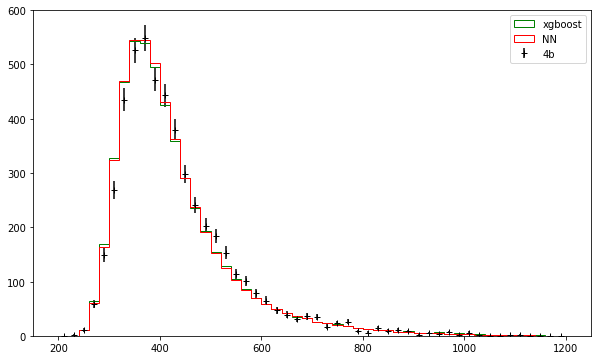

In [641]:
f, ax = plt.subplots(figsize=(10, 6))
mask_4b = data16["ntag"] >= 4
mask_kr = data16["kinematic_region"] == 1

h_4b, be = np.histogram(
    data16.loc[mask_4b & mask_kr, "m_hh"].values, bins=50, range=(200, 1200)
)

h_4b_err = np.sqrt(h_4b)

x = bin_midpoint(be)

ax.errorbar(x, h_4b, yerr=h_4b_err, fmt="k+", label="4b")

mask_2b = data16["ntag"] == 2
mask_kr = data16["kinematic_region"] == 1

h_2b_xgb, _, _ = ax.hist(
    data16.loc[mask_2b & mask_kr, "m_hh"].values,
    bins=be,
    weights=get_mu(fd16, 16, vr=True) * data16.loc[mask_2b & mask_kr, w_col(16, vr =True)].values,
    histtype="step",
    label="xgboost",
    color ='green'
)

mask_2b = data_b16['ntag'] == 2
mask_kr = data_b16['kinematic_region'] == 1

h_2b_nn, _, _ = ax.hist(
    data_b16.loc[mask_2b & mask_kr, "m_hh"].values,
    bins=be,
    weights=get_mu(fdb16, 16,vr=True) * data_b16.loc[mask_2b & mask_kr, w_col(16, vr=True)].values,
    histtype="step",
    label="NN",
    color = 'red',
)
ax.legend()

Text(0.5, 1.0, 'Validation Region Closure\nmodel VR $\\times$ 2b VR = 4b VR ')

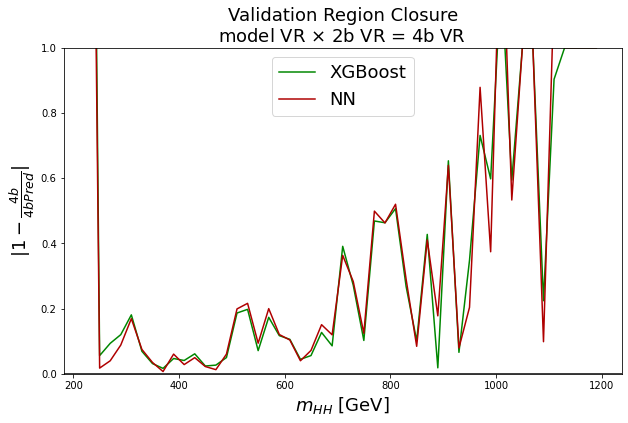

In [642]:
plt.subplots(figsize=(10,6))
plt.plot(x, np.abs(1-(h_4b/h_2b_xgb)), label='XGBoost')
plt.plot(x, np.abs(1-(h_4b/h_2b_nn)), label = 'NN')
plt.axhline(0, color='black')
plt.ylim(0, 1)
plt.legend()
plt.ylabel('$|1-\\frac{4b}{4b Pred}|$', fontsize = 18)
plt.xlabel('$m_{HH}$ [GeV]', fontsize = 18 )
plt.legend(fontsize = 18)
title_str = "Validation Region Closure\n"
title_str+= r"model VR $\times$ 2b VR = 4b VR "
plt.title(title_str, fontsize = 18)

In [602]:
from eda_tools.utilities import getNorm

In [728]:
from eda_tools.bkg_helper import bs_error

In [729]:
help(bs_error)

Help on function bs_error in module eda_tools.bkg_helper:

bs_error(df, kr, be, W_med, W_IQR, mu_med, mu_IQR, feature='m_hh_cor', hrange=(200, 1600))



In [756]:
def model_comparison(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    kr: int = 2,
    model_kr: int = 2,
    label1: str = "label1",
    label2: str = "label2",
    feature: str = "m_hh",
    hrange: tuple = (200, 1200),
    year: int = 16,
    figsize=(10, 6),
    grid_ratio: list = [1.5, 1],
    pull: str = None,
    mu1_iqr=None,
    mu2_iqr=None,
):
    vr = True if model_kr == 1 else False
    f, ax = plt.subplots(
        2, 1, figsize=figsize, sharex=True, gridspec_kw={"height_ratios": grid_ratio}
    )
    mask_4b = df1["ntag"] >= 4
    mask_kr = df1["kinematic_region"] == kr

    h_4b, be = np.histogram(
        df1.loc[mask_4b & mask_kr, feature].values,
        bins=50,
        range=hrange,
    )

    h_4b_err = np.sqrt(h_4b)

    x = bin_midpoint(be)

    ax[0].errorbar(x, h_4b, yerr=h_4b_err, fmt="k+", label="4b")

    mask_2b = df1["ntag"] == 2
    mask_kr = df1["kinematic_region"] == kr

    mu_1 = getNorm(df1, k=model_kr, weight_column=w_col(year, vr=vr))

    h_2b_1, _, _ = ax[0].hist(
        df1.loc[mask_2b & mask_kr, feature].values,
        bins=be,
        weights=mu_1 * df1.loc[mask_2b & mask_kr, w_col(year, vr=vr)].values,
        histtype="step",
        label=label1,
        color="green",
    )
    
    poisson_error1_2b = np.sqrt(
        np.histogram(
            df1.loc[mask_2b & mask_kr, feature].values,
            bins=be,
            weights=(mu_1 * df1.loc[mask_2b & mask_kr, w_col(year, vr=vr)].values)**2,
        )[0]
    )
    
    

    mask_2b = df2["ntag"] == 2
    mask_kr = df2["kinematic_region"] == kr

    mu_2 = getNorm(df2, k=model_kr, weight_column=w_col(year, vr=vr))

    h_2b_2, _, _ = ax[0].hist(
        df2.loc[mask_2b & mask_kr, feature].values,
        bins=be,
        weights=mu_2 * df2.loc[mask_2b & mask_kr, w_col(year, vr=vr)].values,
        histtype="step",
        label=label2,
        color="red",
    )
    poisson_error2_2b = np.sqrt(
        np.histogram(
            df2.loc[mask_2b & mask_kr, feature].values,
            bins=be,
            weights=(mu_2 * df2.loc[mask_2b & mask_kr, w_col(year, vr=vr)].values)**2,
        )[0]
    )

    ax[0].legend()

    if pull is None:
        model1_distance = np.abs(1 - (h_4b / h_2b_1))
        model2_distance = np.abs(1 - (h_4b / h_2b_2))
        ax[1].plot(x, model1_distance, label=label1)
        ax[1].plot(x, model2_distance, label=label2)
        ax[1].set_ylim(0, 1)
        ax[1].set_ylabel("$|1-\\frac{4b}{4b Pred}|$", fontsize=18)

    elif (pull == 'pull') or (pull=='pull_abs'):
        total_error1 = h_4b_err ** 2 + poisson_error1_2b**2
        total_error2 = h_4b_err ** 2 + poisson_error2_2b**2

        if (mu1_iqr is not None) and (mu2_iqr is not None):
            bs_1 = bs_error(
                df1,
                kr=kr,
                be=be,
                W_med=w_col(year, vr=vr),
                W_IQR=w_iqr(year, vr=vr),
                mu_med=mu_1,
                mu_IQR=mu1_iqr,
                feature=feature,
                hrange=hrange,
            )

            bs_2 = bs_error(
                df2,
                kr=kr,
                be=be,
                W_med=w_col(year, vr=vr),
                W_IQR=w_iqr(year, vr=vr),
                mu_med=mu_2,
                mu_IQR=mu2_iqr,
                feature=feature,
                hrange=hrange,
            )
            total_error1 += bs_1["h_err_bs_mag"] ** 2
            total_error2 += bs_2["h_err_bs_mag"] ** 2
            
            pull_model1 = (h_4b - h_2b_1) / (total_error1) ** 0.5
            pull_model2 = (h_4b - h_2b_2) / (total_error2) ** 0.5
        
        if pull == 'pull_abs':
            pull_model1 = np.abs(pull_model1)
            pull_model2 = np.abs(pull_model2)

        ax[1].plot(x, pull_model1, label=label1, marker="+", ls="None")
        ax[1].plot(x, pull_model2, label=label2, marker="+", ls="None")
        if pull == 'pull_abs':
            ax[1].set_ylabel(r"$|\frac{4b - 4b Pred}{Error}$|", fontsize=18)
            ax[1].set_ylim(0, 3)
        elif pull =='pull':
            ax[1].set_ylabel(r"$\frac{4b - 4b Pred}{Error}$", fontsize=18)
            ax[1].set_ylim(-3, 3)
        ax[1].axhline(0, color="grey")
        ax[1].axhline(-2, color="grey", ls="--")
        ax[1].axhline(-1, color="grey", ls="--")
        ax[1].axhline(1, color="grey", ls="--")
        ax[1].axhline(2, color="grey", ls="--")

    ax[1].set_xlabel(feature, fontsize=18)
    ax[1].legend()

    if year == 16:
        year_str = "2016"
    elif year == 17:
        year_str = "2017"
    elif year == 18:
        year_str = "2018"

    test = "Closure: " if model_kr == kr else "Extrapolation: "
    region = "VR" if kr == 1 else "CR"
    model_region = "model VR" if model_kr == 1 else "model CR"
    title_str = (
        year_str
        + " "
        + test
        + model_region
        + r" $\times$ 2b "
        + region
        + "= 4b "
        + region
    )
    ax[0].set_title(title_str, fontsize=18)
    plt.subplots_adjust(hspace=0)
    #print(poisson_error1_2b)
    #print(poisson_error2_2b)
    
    #print(bs_1['h_err_bs_mag'])
    #print(bs_2['h_err_bs_mag'])

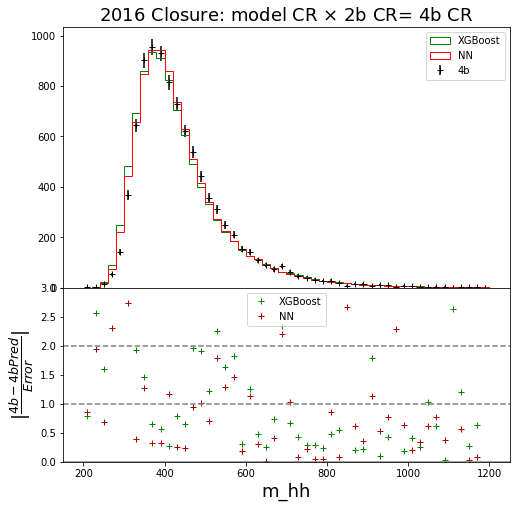

In [757]:
model_comparison(
    data16,
    data_b16,
    kr=2,
    model_kr=2,
    label1="XGBoost",
    label2="NN",
    figsize=(8, 8),
    pull='pull_abs',
    mu1_iqr=get_mu_iqr(fd16, 16),
    mu2_iqr=get_mu_iqr(fdb16, 16),
)

**LETS DO ALL OF THE YEARS**

**CLOSURE CR**

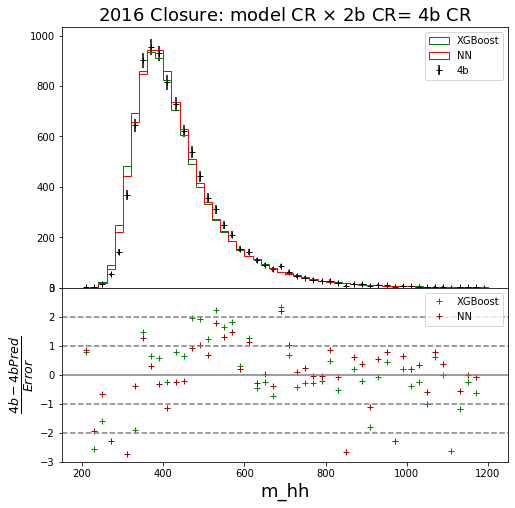

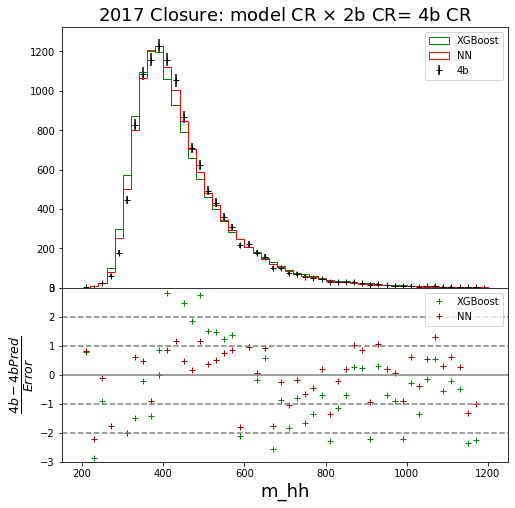

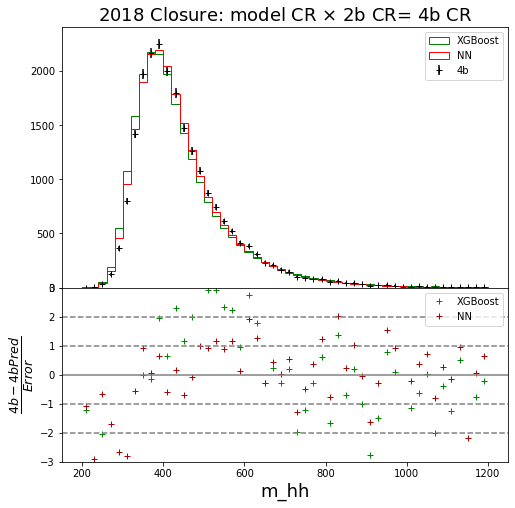

In [747]:
for yr, _df1, _df2, _f, _fb in zip(
    [16, 17, 18], [data16, data17, data18], [data_b16, data_b17, data_b18],[fd16, fd17, fd18], [fdb16, fdb17, fdb18]
):
    model_comparison(
        _df1,
        _df2,
        kr=2,
        model_kr=2,
        label1="XGBoost",
        label2="NN",
        figsize=(8, 8),
        year=yr,
        pull=True,
        mu1_iqr=get_mu_iqr(_f, yr),
        mu2_iqr=get_mu_iqr(_fb, yr),
    )

**CLOSURE VR**

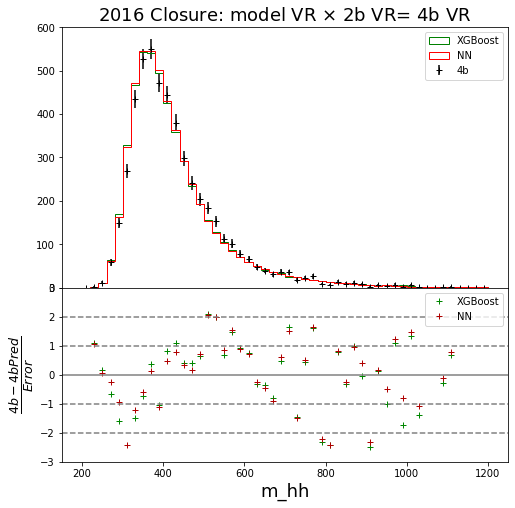

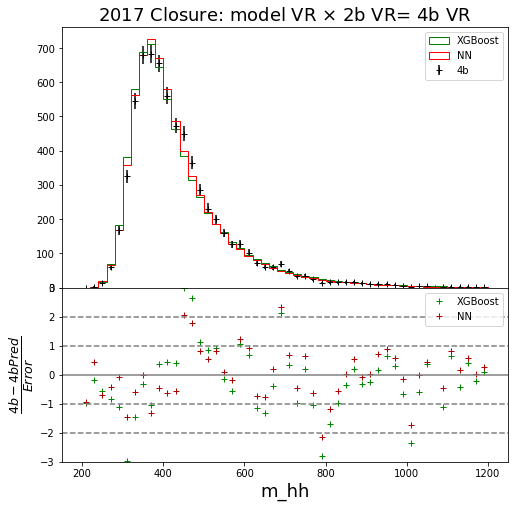

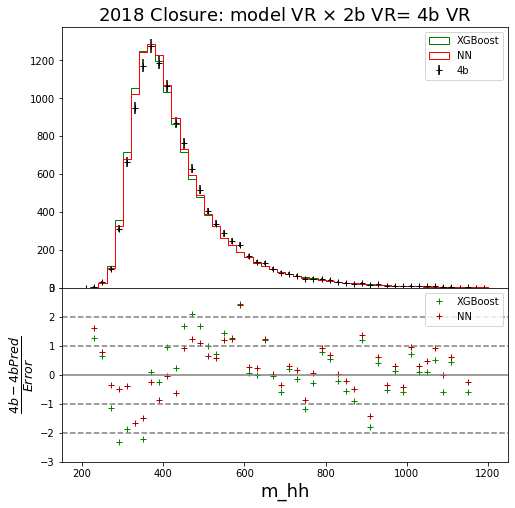

In [750]:
for yr, _df1, _df2, _f, _fb in zip(
    [16, 17, 18], [data16, data17, data18], [data_b16, data_b17, data_b18],[fd16, fd17, fd18], [fdb16, fdb17, fdb18]
):
    model_comparison(
        _df1,
        _df2,
        kr=1,
        model_kr=1,
        label1="XGBoost",
        label2="NN",
        figsize=(8, 8),
        year=yr,
        pull=True,
        mu1_iqr=get_mu_iqr(_f, yr, vr=True),
        mu2_iqr=get_mu_iqr(_fb, yr, vr=True),
    )

In [ ]:
17,

# Extrapolation Check

Lets check to see which model extrapolates better

- NN_CR * VR_2b = VR_4b
- XGB_CR * VR_2b = VR_4b

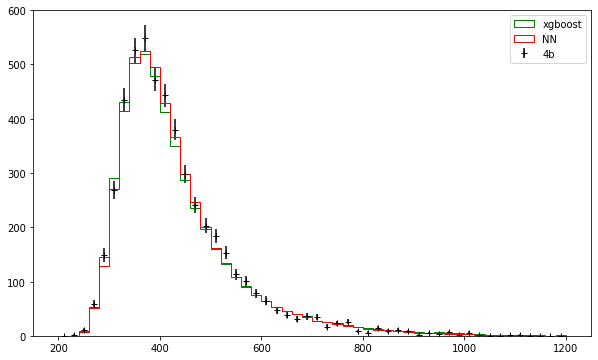

In [643]:
f, ax = plt.subplots(figsize=(10, 6))
mask_4b = data16["ntag"] >= 4
mask_kr = data16["kinematic_region"] == 1

h_4b, be = np.histogram(
    data16.loc[mask_4b & mask_kr, "m_hh"].values, bins=50, range=(200, 1200)
)

h_4b_err = np.sqrt(h_4b)

x = bin_midpoint(be)

ax.errorbar(x, h_4b, yerr=h_4b_err, fmt="k+", label="4b")

mask_2b = data16["ntag"] == 2
mask_kr = data16["kinematic_region"] == 1

h_2b_xgb, _, _ = ax.hist(
    data16.loc[mask_2b & mask_kr, "m_hh"].values,
    bins=be,
    weights=get_mu(fd16, 16) * data16.loc[mask_2b & mask_kr, w_col(16)].values,
    histtype="step",
    label="xgboost",
    color ='green'
)

mask_2b = data_b16['ntag'] == 2
mask_kr = data_b16['kinematic_region'] == 1

h_2b_nn, _, _ = ax.hist(
    data_b16.loc[mask_2b & mask_kr, "m_hh"].values,
    bins=be,
    weights=get_mu(fdb16, 16) * data_b16.loc[mask_2b & mask_kr, w_col(16)].values,
    histtype="step",
    label="NN",
    color = 'red',
)
ax.legend()

Text(0.5, 1.0, 'Validation Region Extrapolation\nmodel CR $\\times$ 2b VR = 4b VR ')

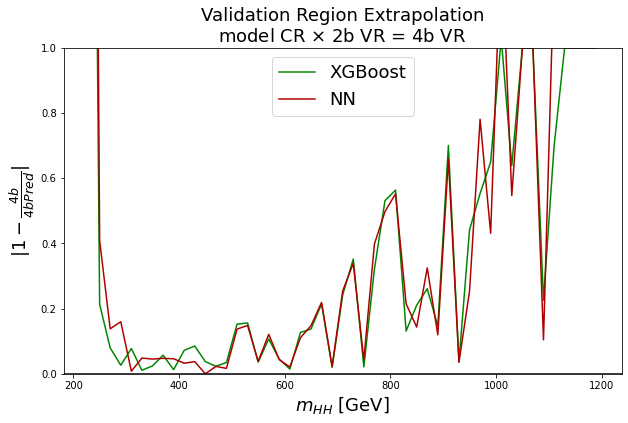

In [644]:
plt.subplots(figsize=(10,6))
plt.plot(x, np.abs(1-(h_4b/h_2b_xgb)), label='XGBoost')
plt.plot(x, np.abs(1-(h_4b/h_2b_nn)), label = 'NN')
plt.axhline(0, color='black')
plt.ylim(0, 1)
plt.legend()
plt.ylabel('$|1-\\frac{4b}{4b Pred}|$', fontsize = 18)
plt.xlabel('$m_{HH}$ [GeV]', fontsize = 18 )
plt.legend(fontsize = 18)
title_str = "Validation Region Extrapolation\n"
title_str+= r"model CR $\times$ 2b VR = 4b VR "

plt.title(title_str, fontsize = 18)

How about 
- XGBoost VR * CR_2b = CR_4b
- NN VR * CR_2b = CR_4b

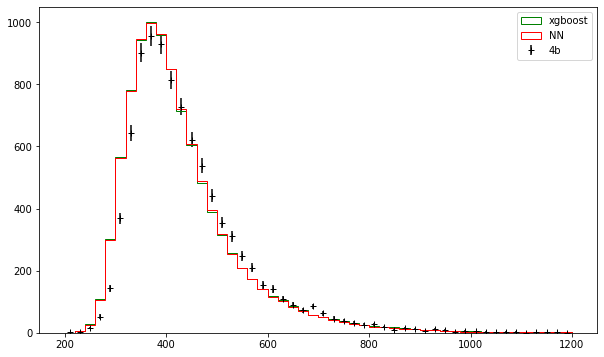

In [646]:
f, ax = plt.subplots(figsize=(10, 6))
mask_4b = data16["ntag"] >= 4
mask_kr = data16["kinematic_region"] == 2

h_4b, be = np.histogram(
    data16.loc[mask_4b & mask_kr, "m_hh"].values, bins=50, range=(200, 1200)
)

h_4b_err = np.sqrt(h_4b)

x = bin_midpoint(be)

ax.errorbar(x, h_4b, yerr=h_4b_err, fmt="k+", label="4b")

mask_2b = data16["ntag"] == 2
mask_kr = data16["kinematic_region"] == 2

h_2b_xgb, _, _ = ax.hist(
    data16.loc[mask_2b & mask_kr, "m_hh"].values,
    bins=be,
    weights=get_mu(fd16, 16, vr=True) * data16.loc[mask_2b & mask_kr, w_col(16, vr=True)].values,
    histtype="step",
    label="xgboost",
    color ='green'
)

mask_2b = data_b16['ntag'] == 2
mask_kr = data_b16['kinematic_region'] == 2

h_2b_nn, _, _ = ax.hist(
    data_b16.loc[mask_2b & mask_kr, "m_hh"].values,
    bins=be,
    weights=get_mu(fdb16, 16, vr=True) * data_b16.loc[mask_2b & mask_kr, w_col(16, vr=True)].values,
    histtype="step",
    label="NN",
    color = 'red',
)
ax.legend()

Text(0.5, 1.0, 'Control Region Extrapolation\nmodel VR $\\times$ 2b CR = 4b CR ')

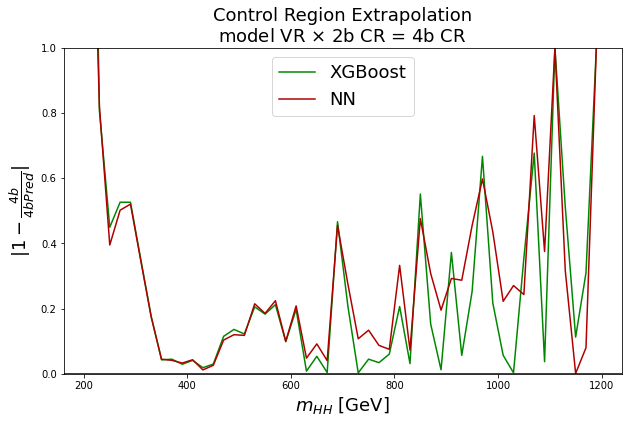

In [647]:
plt.subplots(figsize=(10,6))
plt.plot(x, np.abs(1-(h_4b/h_2b_xgb)), label='XGBoost')
plt.plot(x, np.abs(1-(h_4b/h_2b_nn)), label = 'NN')
plt.axhline(0, color='black')
plt.ylim(0, 1)
plt.legend()
plt.ylabel('$|1-\\frac{4b}{4b Pred}|$', fontsize = 18)
plt.xlabel('$m_{HH}$ [GeV]', fontsize = 18 )
plt.legend(fontsize = 18)
title_str = "Control Region Extrapolation\n"
title_str+= r"model VR $\times$ 2b CR = 4b CR "

plt.title(title_str, fontsize = 18)

**Lets do all of the extrapolation checks for all years**

**Extrapolation CR**

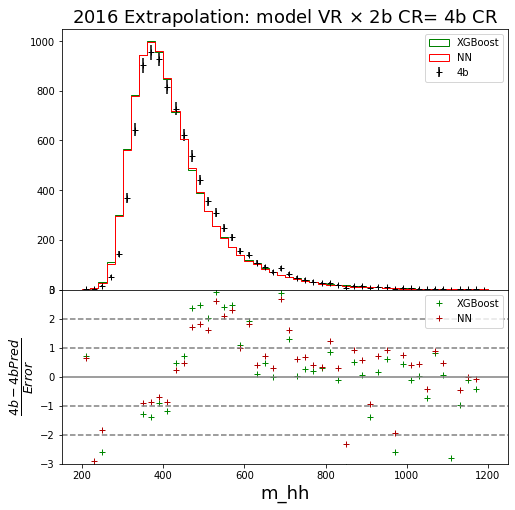

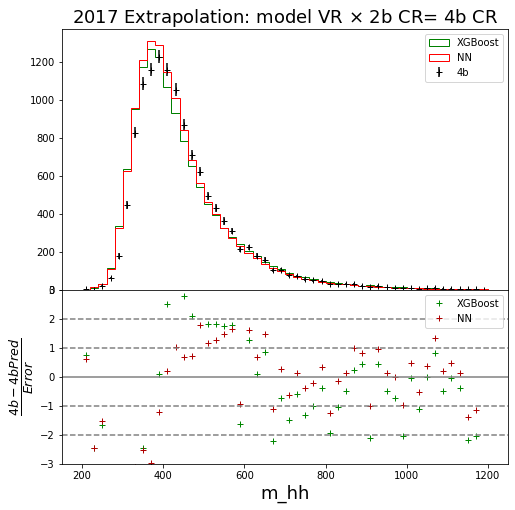

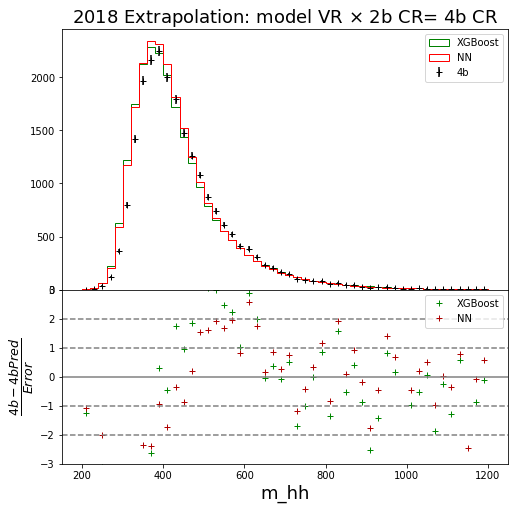

In [752]:
for yr, _df1, _df2, _f, _fb in zip(
    [16, 17, 18], [data16, data17, data18], [data_b16, data_b17, data_b18],[fd16, fd17, fd18], [fdb16, fdb17, fdb18]
):
    model_comparison(
        _df1,
        _df2,
        kr=2,
        model_kr=1,
        label1="XGBoost",
        label2="NN",
        figsize=(8, 8),
        year=yr,
        pull=True,
        mu1_iqr=get_mu_iqr(_f, yr, vr=True),
        mu2_iqr=get_mu_iqr(_fb, yr, vr=True),
    )

**Extrapolation VR**

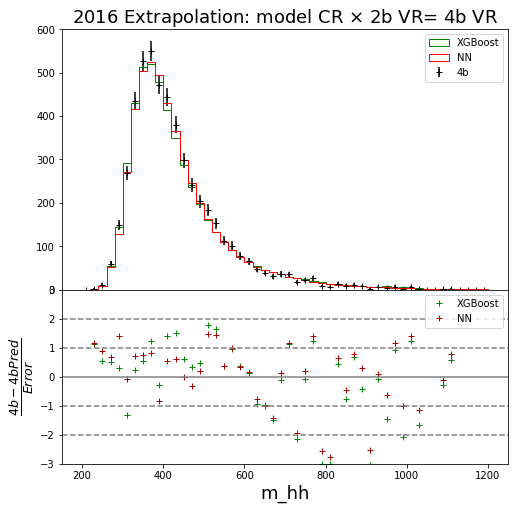

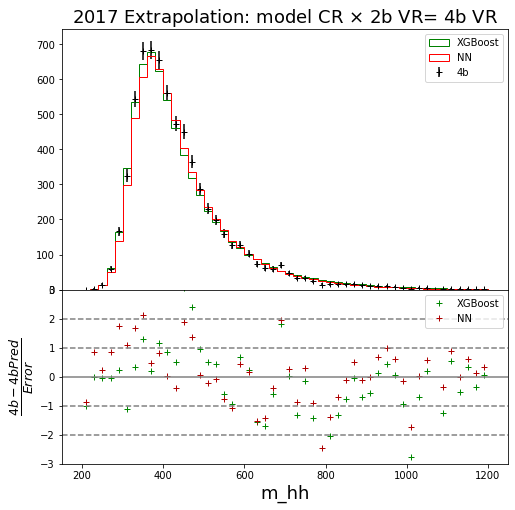

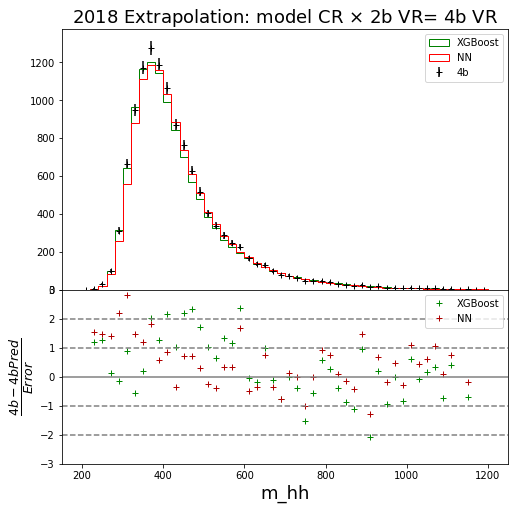

In [751]:
for yr, _df1, _df2, _f, _fb in zip(
    [16, 17, 18], [data16, data17, data18], [data_b16, data_b17, data_b18],[fd16, fd17, fd18], [fdb16, fdb17, fdb18]
):
    model_comparison(
        _df1,
        _df2,
        kr=1,
        model_kr=2,
        label1="XGBoost",
        label2="NN",
        figsize=(8, 8),
        year=yr,
        pull=True,
        mu1_iqr=get_mu_iqr(_f, yr, vr=True),
        mu2_iqr=get_mu_iqr(_fb, yr, vr=True),
    )

# DEBUG ZONE

### Weights comparison

In [1]:
d

NameError: name 'd16' is not defined

In [595]:
get_mu(fd16)

1.0083747507007308

In [596]:
from eda_tools.utilities import getNorm

In [598]:
help(getNorm)

Help on function getNorm in module eda_tools.utilities:

getNorm(df, k, verbose=False, weight_column=None)
    Return the 2b -> 4b normalization in a specified kinematic region
    
    Inputs:
    - df: pandas df for data events
    - k: The kinematic region to calculate this normalization in
         * 2: SB
         * 1: CR
    - verbose: Prints out the value of 4b, 2b and ratio. Return type includes 4b and 2b values



In [601]:
getNorm(data16, k=2, weight_column=w_col(16)) == get_mu(fd16)

True

In [761]:
getNorm(data16, k=1, weight_column=w_col(16, vr=True))

1.013192499194812

In [760]:
get_mu(fd16, vr=True)

1.013192499194812

In [609]:
get_mu(fd16)

1.0083747507007308

In [608]:
getNorm(data16, k=1,weight_column=w_col(16))

1.0345461552420874